In [1]:
# @title Step 1: Import Libraries and Authenticate
import os
import io
import re # For more flexible filename matching
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm # Use notebook version for Colab progress bars
from google.colab import auth
from google.cloud import storage

print("Importing libraries...")

print("Authenticating to Google Cloud...")
try:
    auth.authenticate_user()
    print("Authentication successful.")
except Exception as e:
    print(f"ERROR: Authentication failed: {e}")
    # Depending on the error, you might need to restart the Colab runtime
    # or check your Google Cloud project permissions.
    raise

# Initialize GCS client
gcs_client = None
bucket_name = 'segmentedimages' # <<< YOUR BUCKET NAME HERE
gcs_bucket = None
try:
    gcs_client = storage.Client()
    gcs_bucket = gcs_client.bucket(bucket_name)
    # Test connection by trying to get bucket metadata
    gcs_bucket.reload()
    print(f"GCS Client initialized for bucket: gs://{bucket_name}")
except Exception as e:
    print(f"ERROR: Failed to initialize GCS client or access bucket gs://{bucket_name}. Check bucket name and permissions.")
    print(f"Error details: {e}")
    gcs_client = None # Ensure client is None if initialization failed

Importing libraries...
Authenticating to Google Cloud...
Authentication successful.
GCS Client initialized for bucket: gs://segmentedimages


In [2]:
# @title Step 2 & 3: Define Data Sources and Component Aggregation (Corrected)

# Define the raw source folders for images and masks
# Format: (image_gcs_prefix, mask_gcs_prefix)
# NOTE: Prefixes should end with '/' to indicate folders
data_sources = {
    "labelstudio_busbar_mid": ('labelstudio/busbar_mid/images/', 'labelstudio/busbar_mid/segmented_images/'),
    "labelstudio_plastic_film_aug": ('labelstudio/plastic_film/augment/augmented_images/', 'labelstudio/plastic_film/augment/augmented_masks/'),
    "sreeni_bolt1_aug": ('sreeni/bolt1/augment/augmented_images/', 'sreeni/bolt1/augment/augmented_masks/'),
    "sreeni_bolt2_aug": ('sreeni/bolt2/augment/augmented_images/', 'sreeni/bolt2/augment/augmented_masks/'),
    "sreeni_bolt3_aug": ('sreeni/bolt3/augment/augmented_images/', 'sreeni/bolt3/augment/augmented_masks/'),
    "sreeni_cable_aug": ('sreeni/cable/augment/augmented_images/', 'sreeni/cable/augment/augmented_masks/'),
    "sreeni_connectors_aug": ('sreeni/connectors/augment/augmented_images/', 'sreeni/connectors/augment/augmented_masks/'),
    "sreeni_nut1_aug": ('sreeni/nut1/augment/augmented_images/', 'sreeni/nut1/augment/augmented_masks/'),
    "sreeni_nut2_aug": ('sreeni/nut2/augment/augmented_images/', 'sreeni/nut2/augment/augmented_masks/'),
    "sreeni_plastic_cover_aug": ('sreeni/plastic_cover/augment/augmented_images/', 'sreeni/plastic_cover/augment/augmented_masks/'),
    # --- Corrected sreeni busbar paths ---
    "sreeni_busbar_long": ('sreeni/busbar_long/images/', 'sreeni/busbar_long/segmented_images/'),
    "sreeni_busbar_mid": ('sreeni/busbar_mid/images/', 'sreeni/busbar_mid/segmented_images/'),
    "sreeni_busbar_short": ('sreeni/busbar_short/images/', 'sreeni/busbar_short/segmented_images/'),
}

# Define how raw sources map to final components
component_aggregation = {
    "bolt": ["sreeni_bolt1_aug", "sreeni_bolt2_aug", "sreeni_bolt3_aug"],
    "busbar": ["labelstudio_busbar_mid", "sreeni_busbar_long", "sreeni_busbar_mid", "sreeni_busbar_short"],
    "cable": ["sreeni_cable_aug"],
    "connector": ["sreeni_connectors_aug"], # Expecting ~900 pairs here now
    "nut": ["sreeni_nut1_aug", "sreeni_nut2_aug"],
    "plasticfilm": ["labelstudio_plastic_film_aug"], # Expecting ~700 pairs here
    "plasticcover": ["sreeni_plastic_cover_aug"],
}

print("Data sources (with corrected busbar paths) and component aggregation defined.")

Data sources (with corrected busbar paths) and component aggregation defined.


In [3]:
# @title Step 4: Function to List Files from GCS

def list_gcs_files(bucket, prefix):
    """Lists all files in a GCS bucket with a given prefix."""
    if not bucket:
        print(f"ERROR: GCS bucket not initialized. Cannot list files for prefix: {prefix}")
        return []
    try:
        blobs = bucket.list_blobs(prefix=prefix)
        # Use full gs:// path for uniqueness, skip folders (blobs ending with '/')
        # Convert iterator to list to catch potential errors early and get length
        file_list = [f"gs://{bucket.name}/{blob.name}" for blob in blobs if not blob.name.endswith('/')]
        return file_list
    except Exception as e:
        print(f"ERROR listing files in gs://{bucket.name}/{prefix}: {e}")
        return []

print("GCS file listing function defined.")

GCS file listing function defined.


In [4]:
# @title Step 5 & 6: Aggregate File Paths and Match Images/Masks (with Enhanced Debugging)

def get_base_filename(gcs_path):
    """Extracts the base filename for matching purposes, handling variations."""
    filename = os.path.basename(gcs_path)
    # Remove common image extensions first
    base = re.sub(r'\.(jpg|jpeg|png|bmp|tiff)$', '', filename, flags=re.IGNORECASE)
    # Then remove common mask suffixes (case-insensitive just in case)
    base = re.sub(r'_semantic_mask$', '', base, flags=re.IGNORECASE)
    # Add any other specific suffix removals if needed based on examples
    # e.g., if some masks end in _mask.png instead of _semantic_mask.png
    # base = re.sub(r'_mask$', '', base, flags=re.IGNORECASE)
    return base

def match_images_masks(image_paths, mask_paths):
    """Matches image paths to mask paths based on derived base filenames."""
    # Create map from base mask filename to full mask path
    # Use a list to handle potential duplicate base names from masks
    mask_map = {}
    for p in mask_paths:
        base_name = get_base_filename(p)
        if base_name not in mask_map:
            mask_map[base_name] = []
        mask_map[base_name].append(p)

    matched_pairs = []
    unmatched_images = []
    processed_mask_paths = set() # Keep track of masks that HAVE been matched

    print(f"Attempting to match {len(image_paths)} images with {len(mask_paths)} masks...")

    # --- Debugging: Check for duplicate base names derived from images ---
    image_base_names = {}
    for img_path in image_paths:
        base_name = get_base_filename(img_path)
        if base_name not in image_base_names:
            image_base_names[base_name] = 0
        image_base_names[base_name] += 1
    duplicate_image_bases = {k: v for k, v in image_base_names.items() if v > 1}
    if duplicate_image_bases:
        print(f"\nWarning: Found {len(duplicate_image_bases)} base filenames derived from multiple images. This could cause issues if masks don't also have duplicates.")
        # print("Example duplicate base names (from images):", list(duplicate_image_bases.keys())[:5])
    # --- End Debugging ---

    for img_path in tqdm(image_paths, desc="Matching images"):
        base_name = get_base_filename(img_path)
        if base_name in mask_map:
            # Find the best matching mask (simple case: take the first one)
            potential_masks = mask_map[base_name]
            if potential_masks: # Check if there are still masks available for this base name
                mask_path_to_use = potential_masks.pop(0) # Take the first available mask
                if not potential_masks: # Remove entry from dict if list is now empty
                    del mask_map[base_name]

                matched_pairs.append((img_path, mask_path_to_use))
                processed_mask_paths.add(mask_path_to_use) # Mark this specific mask path as used
            else:
                # This case should ideally not happen if initial counts match and base names are unique,
                # but could occur if an image base name is duplicated but the mask base name isn't.
                print(f"Warning: Image base name '{base_name}' found in mask_map keys, but the list was empty. Image: {os.path.basename(img_path)}")
                unmatched_images.append(img_path)
        else:
            unmatched_images.append(img_path)

    # Calculate unmatched masks *after* iterating through all images
    # These are masks whose full path wasn't added to processed_mask_paths
    unmatched_masks = [p for p in mask_paths if p not in processed_mask_paths]

    # --- Reporting ---
    print(f"\nSuccessfully matched {len(matched_pairs)} image/mask pairs.") # Matches found

    if unmatched_images:
        print(f"Warning: Found {len(unmatched_images)} images without corresponding masks.")
        print("--> First 5 unmatched image filenames:")
        for i, img_p in enumerate(unmatched_images[:5]):
             print(f"    {i+1}. {os.path.basename(img_p)} (Derived base: '{get_base_filename(img_p)}')") # Also show derived base

    if unmatched_masks:
        print(f"Warning: Found {len(unmatched_masks)} masks without corresponding images.")
        # --- MODIFICATION: Print more details about unmatched masks ---
        print(f"--> First 20 unmatched mask filenames (out of {len(unmatched_masks)}):")
        for i, mask_p in enumerate(unmatched_masks[:20]):
             base_name = get_base_filename(mask_p)
             print(f"    {i+1}. {os.path.basename(mask_p)} (Derived base: '{base_name}')")
        if len(unmatched_masks) > 20:
             print("    ...")
        # --- END MODIFICATION ---

    # --- Debugging: Check if any masks had duplicate base names initially ---
    duplicate_mask_bases = []
    temp_mask_bases = {}
    for p in mask_paths:
        base_name = get_base_filename(p)
        if base_name not in temp_mask_bases:
             temp_mask_bases[base_name] = 0
        temp_mask_bases[base_name] += 1
        if temp_mask_bases[base_name] == 2: # Report only once when it becomes a duplicate
             duplicate_mask_bases.append(base_name)
    if duplicate_mask_bases:
         print(f"\nNote: Found {len(duplicate_mask_bases)} base filenames derived from multiple masks initially.")
         # print("Example duplicate base names (from masks):", duplicate_mask_bases[:5])
    # --- End Debugging ---

    return matched_pairs

print("File matching function ('match_images_masks') updated with enhanced debugging output.")

File matching function ('match_images_masks') updated with enhanced debugging output.


In [5]:
# @title Step 5b: Run Aggregation and Matching

all_component_data = {}
total_matched_pairs = 0

if gcs_client and gcs_bucket: # Proceed only if GCS connection is okay
    print("\nStarting file aggregation and matching process...")

    for component, source_keys in component_aggregation.items():
        print(f"\nProcessing component: {component.upper()}")
        component_image_paths = []
        component_mask_paths = []
        valid_component = True

        for key in source_keys:
            if key not in data_sources:
                print(f"  Warning: Source key '{key}' not found in data_sources definition. Skipping.")
                continue

            img_prefix, mask_prefix = data_sources[key]
            print(f"  Listing files from gs://{bucket_name}/{img_prefix} and gs://{bucket_name}/{mask_prefix}")

            # List images
            current_image_paths = list_gcs_files(gcs_bucket, img_prefix)
            if not current_image_paths and img_prefix: # Avoid warning if prefix was intentionally empty
                 print(f"    Warning: No image files found in gs://{bucket_name}/{img_prefix}")
                 # Decide if this is critical - maybe set valid_component = False?
            component_image_paths.extend(current_image_paths)
            print(f"    Found {len(current_image_paths)} images.")

            # List masks
            current_mask_paths = list_gcs_files(gcs_bucket, mask_prefix)
            if not current_mask_paths and mask_prefix:
                 print(f"    Warning: No mask files found in gs://{bucket_name}/{mask_prefix}")
                 # Decide if this is critical
            component_mask_paths.extend(current_mask_paths)
            print(f"    Found {len(current_mask_paths)} masks.")

            # Basic check for equal numbers in this sub-source (optional but helpful)
            # if len(current_image_paths) != len(current_mask_paths):
            #     print(f"    Warning: Mismatch in count for source '{key}'. Images: {len(current_image_paths)}, Masks: {len(current_mask_paths)}")


        if not component_image_paths or not component_mask_paths:
             print(f"  Skipping matching for {component} due to missing images or masks in its sources.")
             all_component_data[component] = [] # Store empty list for this component
             continue # Skip to next component

        print(f"  Total raw images listed for {component}: {len(component_image_paths)}")
        print(f"  Total raw masks listed for {component}: {len(component_mask_paths)}")

        # Match images and masks for the current aggregated component
        matched_pairs = match_images_masks(component_image_paths, component_mask_paths)
        all_component_data[component] = matched_pairs
        total_matched_pairs += len(matched_pairs)
        print(f"  Finished processing {component}. Matched pairs stored: {len(matched_pairs)}")

    print(f"\n--- Data Aggregation and Matching Complete ---")
    print(f"Total matched image/mask pairs across all components: {total_matched_pairs}")

    # Print summary per component
    print("\nMatched pairs per component:")
    for component, pairs in all_component_data.items():
        print(f"- {component}: {len(pairs)}")

else:
    print("\nERROR: GCS client/bucket not initialized. Cannot proceed with file aggregation.")
    print("Please check authentication and bucket name in Step 1.")


Starting file aggregation and matching process...

Processing component: BOLT
  Listing files from gs://segmentedimages/sreeni/bolt1/augment/augmented_images/ and gs://segmentedimages/sreeni/bolt1/augment/augmented_masks/
    Found 600 images.
    Found 600 masks.
  Listing files from gs://segmentedimages/sreeni/bolt2/augment/augmented_images/ and gs://segmentedimages/sreeni/bolt2/augment/augmented_masks/
    Found 600 images.
    Found 600 masks.
  Listing files from gs://segmentedimages/sreeni/bolt3/augment/augmented_images/ and gs://segmentedimages/sreeni/bolt3/augment/augmented_masks/
    Found 600 images.
    Found 600 masks.
  Total raw images listed for bolt: 1800
  Total raw masks listed for bolt: 1800
Attempting to match 1800 images with 1800 masks...



Matching images:   0%|          | 0/1800 [00:00<?, ?it/s]


Successfully matched 1800 image/mask pairs.

Note: Found 75 base filenames derived from multiple masks initially.
  Finished processing bolt. Matched pairs stored: 1800

Processing component: BUSBAR
  Listing files from gs://segmentedimages/labelstudio/busbar_mid/images/ and gs://segmentedimages/labelstudio/busbar_mid/segmented_images/
    Found 208 images.
    Found 208 masks.
  Listing files from gs://segmentedimages/sreeni/busbar_long/images/ and gs://segmentedimages/sreeni/busbar_long/segmented_images/
    Found 598 images.
    Found 598 masks.
  Listing files from gs://segmentedimages/sreeni/busbar_mid/images/ and gs://segmentedimages/sreeni/busbar_mid/segmented_images/
    Found 384 images.
    Found 384 masks.
  Listing files from gs://segmentedimages/sreeni/busbar_short/images/ and gs://segmentedimages/sreeni/busbar_short/segmented_images/
    Found 641 images.
    Found 641 masks.
  Total raw images listed for busbar: 1831
  Total raw masks listed for busbar: 1831
Attempting 

Matching images:   0%|          | 0/1831 [00:00<?, ?it/s]


Successfully matched 1831 image/mask pairs.

Note: Found 272 base filenames derived from multiple masks initially.
  Finished processing busbar. Matched pairs stored: 1831

Processing component: CABLE
  Listing files from gs://segmentedimages/sreeni/cable/augment/augmented_images/ and gs://segmentedimages/sreeni/cable/augment/augmented_masks/
    Found 1800 images.
    Found 1800 masks.
  Total raw images listed for cable: 1800
  Total raw masks listed for cable: 1800
Attempting to match 1800 images with 1800 masks...


Matching images:   0%|          | 0/1800 [00:00<?, ?it/s]


Successfully matched 1800 image/mask pairs.
  Finished processing cable. Matched pairs stored: 1800

Processing component: CONNECTOR
  Listing files from gs://segmentedimages/sreeni/connectors/augment/augmented_images/ and gs://segmentedimages/sreeni/connectors/augment/augmented_masks/
    Found 700 images.
    Found 700 masks.
  Total raw images listed for connector: 700
  Total raw masks listed for connector: 700
Attempting to match 700 images with 700 masks...


Matching images:   0%|          | 0/700 [00:00<?, ?it/s]


Successfully matched 700 image/mask pairs.
  Finished processing connector. Matched pairs stored: 700

Processing component: NUT
  Listing files from gs://segmentedimages/sreeni/nut1/augment/augmented_images/ and gs://segmentedimages/sreeni/nut1/augment/augmented_masks/
    Found 900 images.
    Found 900 masks.
  Listing files from gs://segmentedimages/sreeni/nut2/augment/augmented_images/ and gs://segmentedimages/sreeni/nut2/augment/augmented_masks/
    Found 900 images.
    Found 900 masks.
  Total raw images listed for nut: 1800
  Total raw masks listed for nut: 1800
Attempting to match 1800 images with 1800 masks...



Matching images:   0%|          | 0/1800 [00:00<?, ?it/s]


Successfully matched 1800 image/mask pairs.

Note: Found 88 base filenames derived from multiple masks initially.
  Finished processing nut. Matched pairs stored: 1800

Processing component: PLASTICFILM
  Listing files from gs://segmentedimages/labelstudio/plastic_film/augment/augmented_images/ and gs://segmentedimages/labelstudio/plastic_film/augment/augmented_masks/
    Found 700 images.
    Found 700 masks.
  Total raw images listed for plasticfilm: 700
  Total raw masks listed for plasticfilm: 700
Attempting to match 700 images with 700 masks...


Matching images:   0%|          | 0/700 [00:00<?, ?it/s]


Successfully matched 700 image/mask pairs.
  Finished processing plasticfilm. Matched pairs stored: 700

Processing component: PLASTICCOVER
  Listing files from gs://segmentedimages/sreeni/plastic_cover/augment/augmented_images/ and gs://segmentedimages/sreeni/plastic_cover/augment/augmented_masks/
    Found 1800 images.
    Found 1800 masks.
  Total raw images listed for plasticcover: 1800
  Total raw masks listed for plasticcover: 1800
Attempting to match 1800 images with 1800 masks...


Matching images:   0%|          | 0/1800 [00:00<?, ?it/s]


Successfully matched 1800 image/mask pairs.
  Finished processing plasticcover. Matched pairs stored: 1800

--- Data Aggregation and Matching Complete ---
Total matched image/mask pairs across all components: 10431

Matched pairs per component:
- bolt: 1800
- busbar: 1831
- cable: 1800
- connector: 700
- nut: 1800
- plasticfilm: 700
- plasticcover: 1800


In [6]:
# @title Step 7: Define Label Remapping

# Original labels: background-0, bolt-1, busbar-3, cable-4, connector-5, nut-6, plasticfilm-7, plasticcover-8
# Remapped labels: background-0, bolt-1, busbar-2, cable-3, connector-4, nut-5, plasticfilm-6, plasticcover-7
# Class ID 2 is assumed to be the unused/removed component.

original_to_remapped_dict = {
    0: 0,  # background -> background
    1: 1,  # bolt -> bolt
    # Original class 2 is missing/removed
    3: 2,  # busbar -> busbar
    4: 3,  # cable -> cable
    5: 4,  # connector -> connector
    6: 5,  # nut -> nut
    7: 6,  # plasticfilm -> plasticfilm
    8: 7   # plasticcover -> plasticcover
}

# Create a lookup array for efficiency (vectorized remapping)
# Find the maximum original label ID that *needs* mapping
max_original_label = 0
if original_to_remapped_dict: # Check if dictionary is not empty
    max_original_label = max(original_to_remapped_dict.keys())

# Initialize lookup table with a default value (e.g., 0 for background or an unused value)
# Size needs to be max_original_label + 1 to include index max_original_label
# Using 0 as default: if an unexpected label appears, map it to background.
lookup_table = np.zeros(max_original_label + 1, dtype=np.uint8)
for original_id, remapped_id in original_to_remapped_dict.items():
    lookup_table[original_id] = remapped_id

print("\nLabel remapping dictionary and lookup table created:")
print("Original -> Remapped Dictionary:", original_to_remapped_dict)
# print("Lookup Table (Index is Original ID, Value is Remapped ID):") # Can be long
# print(lookup_table)


Label remapping dictionary and lookup table created:
Original -> Remapped Dictionary: {0: 0, 1: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}


In [7]:
# @title Step 8: Create Mask Remapping Function

def remap_mask_labels(mask_array, lookup_table):
    """Remaps labels in a mask array using a lookup table."""
    # Ensure mask_array is numpy array
    if not isinstance(mask_array, np.ndarray):
        raise TypeError("Input mask must be a NumPy array.")
    if mask_array.size == 0:
         print("Warning: Received an empty mask array. Returning empty array.")
         return mask_array # Return empty array if input is empty

    # Check if any values in the mask are outside the bounds of the lookup table
    max_val_in_mask = np.max(mask_array)
    max_supported_label = len(lookup_table) - 1

    if max_val_in_mask > max_supported_label:
         print(f"Warning: Mask contains value ({max_val_in_mask}) larger than max original label supported by lookup table ({max_supported_label}).")
         # Identify problematic pixels
         problematic_pixels = mask_array > max_supported_label
         unique_problematic_values = np.unique(mask_array[problematic_pixels])
         print(f"  Unique problematic values found: {unique_problematic_values}")
         print(f"  These pixels will be mapped to lookup_table[0] ({lookup_table[0]}) due to current implementation.") # Or error if numpy raises index error
         # Option: Clip values before lookup (maps high values to max supported remapped value)
         # mask_array_clipped = np.clip(mask_array, 0, max_supported_label)
         # remapped_mask = lookup_table[mask_array_clipped]
         # Option: Map problematic pixels to a specific value (e.g., 0 for background) after lookup
         remapped_mask = lookup_table[np.clip(mask_array, 0, max_supported_label)] # Apply lookup on clipped values
         remapped_mask[problematic_pixels] = 0 # Force problematic pixels to background
         print(f"  Forcing these pixel values to 0 (background).")
         return remapped_mask
         # Option: Raise error
         # raise ValueError(f"Mask contains value ({max_val_in_mask}) outside lookup table range [0, {max_supported_label}]. Problematic values: {unique_problematic_values}")

    # Apply the lookup table - this is efficient vectorized remapping
    remapped_mask = lookup_table[mask_array]
    return remapped_mask

print("Mask remapping function defined.")

Mask remapping function defined.


In [8]:
# @title Step 9: Define Loading Functions

def load_image_from_gcs(gcs_path, bucket):
    """Loads an image from GCS path into a PIL Image object."""
    if not bucket:
        print(f"ERROR: GCS bucket not initialized. Cannot load image {gcs_path}")
        return None
    try:
        blob_name = gcs_path.replace(f"gs://{bucket.name}/", "")
        blob = bucket.blob(blob_name)
        content = blob.download_as_bytes()
        img = Image.open(io.BytesIO(content))
        # Ensure image is in RGB format (common requirement for models)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image {gcs_path}: {e}")
        return None

def load_mask_from_gcs(gcs_path, bucket):
    """Loads a mask from GCS path into a NumPy array."""
    if not bucket:
        print(f"ERROR: GCS bucket not initialized. Cannot load mask {gcs_path}")
        return None
    try:
        blob_name = gcs_path.replace(f"gs://{bucket.name}/", "")
        blob = bucket.blob(blob_name)
        content = blob.download_as_bytes()
        # Assume masks are grayscale (single channel).
        # 'L' mode is 8-bit pixels, black and white.
        mask_pil = Image.open(io.BytesIO(content)).convert('L')
        return np.array(mask_pil)
    except Exception as e:
        print(f"Error loading mask {gcs_path}: {e}")
        return None

print("Image and mask loading functions defined.")

Image and mask loading functions defined.



--- Example: Loading and Remapping first 'cable' mask ---
Loading image: gs://segmentedimages/sreeni/cable/augment/augmented_images/1_frame_0150.jpg
Loading mask: gs://segmentedimages/sreeni/cable/augment/augmented_masks/1_frame_0150_semantic_mask.png

Original mask properties:
  - Shape: (1920, 1080)
  - Data type: uint8
  - Unique labels found: [0 1 4 5]

Remapping mask labels...

Remapped mask properties:
  - Shape: (1920, 1080)
  - Data type: uint8
  - Unique labels found: [0 1 3 4]

Verification (Original Label -> Remapped Label):
  0 -> 0
  1 -> 1
  4 -> 3
  5 -> 4


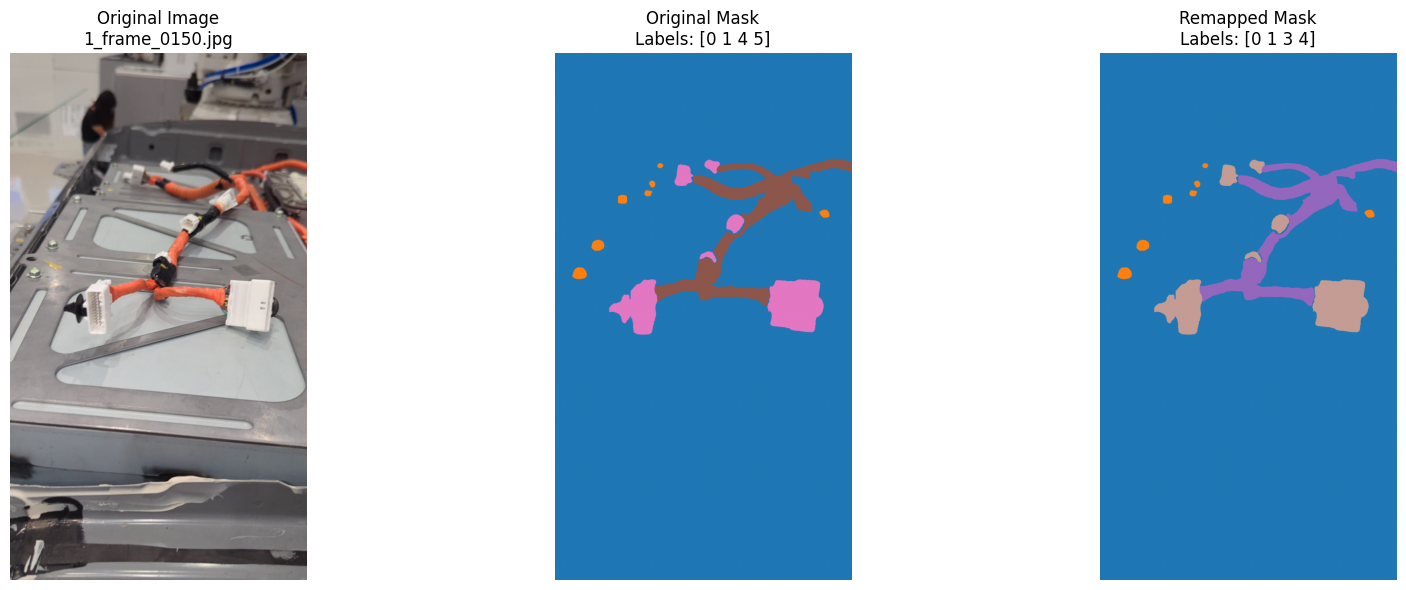


--- Full Data Preparation Script Finished ---
Variable 'all_component_data' holds the matched (image_path, mask_path) pairs for each component.
Use 'load_image_from_gcs' and 'load_mask_from_gcs' to load data.
Use 'remap_mask_labels(mask_array, lookup_table)' to remap loaded masks.
Review any WARNING or ERROR messages above.


In [9]:
# @title Step 10: Example - Loading and Remapping a Mask (Optional)

# --- Select a component to test (if data exists) ---
test_component = 'cable' # Change to 'busbar', 'cable', etc. if needed

if gcs_client and gcs_bucket and test_component in all_component_data and all_component_data[test_component]:
    print(f"\n--- Example: Loading and Remapping first '{test_component}' mask ---")
    # Get the first matched pair for the test component
    example_img_path, example_mask_path = all_component_data[test_component][0]

    print(f"Loading image: {example_img_path}")
    example_image = load_image_from_gcs(example_img_path, gcs_bucket)

    print(f"Loading mask: {example_mask_path}")
    original_mask_array = load_mask_from_gcs(example_mask_path, gcs_bucket)

    if original_mask_array is not None:
        print("\nOriginal mask properties:")
        print("  - Shape:", original_mask_array.shape)
        print("  - Data type:", original_mask_array.dtype)
        original_unique_labels = np.unique(original_mask_array)
        print("  - Unique labels found:", original_unique_labels)

        # Remap the labels
        print("\nRemapping mask labels...")
        remapped_mask_array = remap_mask_labels(original_mask_array, lookup_table)

        print("\nRemapped mask properties:")
        print("  - Shape:", remapped_mask_array.shape)
        print("  - Data type:", remapped_mask_array.dtype)
        remapped_unique_labels = np.unique(remapped_mask_array)
        print("  - Unique labels found:", remapped_unique_labels)

        # Verification printout
        print("\nVerification (Original Label -> Remapped Label):")
        max_supported_label = len(lookup_table) - 1
        labels_to_verify = sorted(list(original_unique_labels))
        for label in labels_to_verify:
             if label <= max_supported_label:
                 print(f"  {label} -> {lookup_table[label]}")
             else:
                 # How it was handled depends on the logic in remap_mask_labels
                 print(f"  {label} -> (Original value > {max_supported_label}, mapped according to warning logic, likely 0)")

        # --- Optional: Display using Matplotlib ---
        try:
            import matplotlib.pyplot as plt
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            # Image
            if example_image:
                axes[0].imshow(example_image)
                axes[0].set_title(f"Original Image\n{os.path.basename(example_img_path)}")
            else:
                 axes[0].set_title("Image Load Failed")
            axes[0].axis('off')

            # Original Mask
            im1 = axes[1].imshow(original_mask_array, cmap='tab20', vmin=0, vmax=max(original_unique_labels.max(), max_original_label, 1)) # Use a colormap, adjust max value
            axes[1].set_title(f"Original Mask\nLabels: {original_unique_labels}")
            axes[1].axis('off')
            # fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04) # Optional colorbar

            # Remapped Mask
            im2 = axes[2].imshow(remapped_mask_array, cmap='tab20', vmin=0, vmax=max(remapped_unique_labels.max(), np.max(lookup_table), 1)) # Adjust max value for remapped labels
            axes[2].set_title(f"Remapped Mask\nLabels: {remapped_unique_labels}")
            axes[2].axis('off')
            # fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04) # Optional colorbar

            plt.tight_layout()
            plt.show()
        except ImportError:
            print("\nMatplotlib not found. Cannot display images/masks.")
        except Exception as display_e:
             print(f"\nError during display: {display_e}")
        # --- End Optional Display ---

    else:
        print(f"Failed to load the example mask: {example_mask_path}")
elif not (gcs_client and gcs_bucket):
     print("\nSkipping example: GCS client/bucket not initialized.")
elif test_component not in all_component_data:
     print(f"\nSkipping example: Component '{test_component}' not found in aggregation results.")
elif not all_component_data[test_component]:
      print(f"\nSkipping example: No matched pairs found for component '{test_component}'.")


print("\n--- Full Data Preparation Script Finished ---")
print("Variable 'all_component_data' holds the matched (image_path, mask_path) pairs for each component.")
print("Use 'load_image_from_gcs' and 'load_mask_from_gcs' to load data.")
print("Use 'remap_mask_labels(mask_array, lookup_table)' to remap loaded masks.")
print("Review any WARNING or ERROR messages above.")

In [10]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [11]:
# @title Step 11: Install Necessary Libraries (Pin Versions, Uninstall Conflicts - FOR FRESH RUNTIME)

# --- Uninstall potentially conflicting packages FIRST (less critical on fresh runtime, but good practice) ---
print("Uninstalling potentially conflicting packages (tensorflow, numba, pytensor)...")
# Use -y to automatically confirm uninstallation
!pip uninstall tensorflow numba pytensor -y -q

# --- Install desired PyTorch versions (Pinned) and dependencies ---
# Checked nvcc --version output, which reported CUDA 12.5.
# Using the cu121 index URL for PyTorch builds compatible with CUDA 12.x.
CUDA_VERSION_SUFFIX = "cu121"
TORCH_VERSION = "2.3.1"       # Known stable version
TORCHVISION_VERSION = "0.18.1" # Compatible with torch 2.3.1
TORCHAUDIO_VERSION = "2.3.1"    # Compatible with torch 2.3.1

print(f"\nAttempting PyTorch install for index: {CUDA_VERSION_SUFFIX} (Pinned Versions)")
print(f"Torch: {TORCH_VERSION}, Torchvision: {TORCHVISION_VERSION}, Torchaudio: {TORCHAUDIO_VERSION}")

# Use regular install on fresh runtime, no-cache is still good
!pip install --no-cache-dir torch=={TORCH_VERSION} torchvision=={TORCHVISION_VERSION} torchaudio=={TORCHAUDIO_VERSION} --index-url https://download.pytorch.org/whl/{CUDA_VERSION_SUFFIX} -q
# Install the other dependencies
!pip install --no-cache-dir albumentations -q
!pip install --no-cache-dir torchmetrics -q
!pip install --no-cache-dir tqdm -q

print(f"\nLibraries installed/checked for target CUDA suffix: {CUDA_VERSION_SUFFIX} with pinned versions.")

# --- Check if core libraries load ---
print("\nPerforming post-install check...")
INSTALL_SUCCESS = False # Default to False
try:
    import torch
    import torchvision
    import torchaudio # Check torchaudio too
    import albumentations
    import torchmetrics
    print(f"Torch version: {torch.__version__} (Target: {TORCH_VERSION})")
    print(f"Torchvision version: {torchvision.__version__} (Target: {TORCHVISION_VERSION})")
    print(f"Torchaudio version: {torchaudio.__version__} (Target: {TORCHAUDIO_VERSION})")
    # Check the CUDA version torch *thinks* it was built with
    print(f"Torch CUDA version detected by torch: {torch.version.cuda}")

    # Check compatibility
    print("Running internal compatibility check...")
    device_check = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        # *** CORRECTED roi_align CALL with dtype=torch.float32 ***
        torchvision.ops.roi_align(torch.rand(1, 1, 10, 10, device=device_check), torch.tensor([[0, 0, 0, 5, 5]], dtype=torch.float32, device=device_check), output_size=1)
        print("Internal CUDA compatibility check passed.")
    else:
         print("Skipping CUDA check as no GPU is available.")


    # Explicit version check
    if torch.__version__.startswith(TORCH_VERSION) and \
       torchvision.__version__.startswith(TORCHVISION_VERSION) and \
       torchaudio.__version__.startswith(TORCHAUDIO_VERSION):
        print(">>> Basic Torch/Torchvision/Torchaudio version check PASSED. <<<")
        # Check if torch CUDA version matches target (12.1 for cu121)
        if torch.version.cuda is not None and torch.version.cuda.startswith("12.1"):
             print(f">>> Torch CUDA version ({torch.version.cuda}) matches target index ({CUDA_VERSION_SUFFIX}). <<<")
             INSTALL_SUCCESS = True
        elif torch.version.cuda is None and not torch.cuda.is_available():
             print(">>> Torch CPU version installed, no CUDA check needed. <<<")
             INSTALL_SUCCESS = True # Allow CPU install to succeed
        else:
             print(f"!!! Version Check FAILED: Torch CUDA version ({torch.version.cuda}) does NOT match target index ({CUDA_VERSION_SUFFIX}). !!!")
             INSTALL_SUCCESS = False
    else:
        print("!!! Version Check FAILED: Installed versions do not match pinned targets. !!!")
        INSTALL_SUCCESS = False

except RuntimeError as e:
    # Catch the specific error if it still happens, or other runtime errors
    print(f"!!! Compatibility Check FAILED (RuntimeError): {e} !!!")
    INSTALL_SUCCESS = False
except ImportError as e:
    print(f"!!! Failed to import one of the core libraries: {e} !!!")
    INSTALL_SUCCESS = False
except Exception as e:
     print(f"!!! An unexpected error occurred during the check: {e} !!!")
     INSTALL_SUCCESS = False


if INSTALL_SUCCESS:
    print("\n**************************************************************************************")
    print(">>> ACTION REQUIRED: Installation and checks successful. Please go to 'Runtime' -> 'Restart runtime' NOW. <<<")
    print(">>> After restarting, re-run all cells sequentially from Step 1 onwards. <<<")
    print("**************************************************************************************")
else:
    print("\n!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(">>> WARNING: Installation failed or basic checks did not pass. <<<")
    print(">>> DO NOT RESTART RUNTIME YET. Review the errors above. <<<")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

Uninstalling potentially conflicting packages (tensorflow, numba, pytensor)...

Attempting PyTorch install for index: cu121 (Pinned Versions)
Torch: 2.3.1, Torchvision: 0.18.1, Torchaudio: 2.3.1

Libraries installed/checked for target CUDA suffix: cu121 with pinned versions.

Performing post-install check...
Torch version: 2.3.1+cu121 (Target: 2.3.1)
Torchvision version: 0.18.1+cu121 (Target: 0.18.1)
Torchaudio version: 2.3.1+cu121 (Target: 2.3.1)
Torch CUDA version detected by torch: 12.1
Running internal compatibility check...
Internal CUDA compatibility check passed.
>>> Basic Torch/Torchvision/Torchaudio version check PASSED. <<<
>>> Torch CUDA version (12.1) matches target index (cu121). <<<

**************************************************************************************
>>> ACTION REQUIRED: Installation and checks successful. Please go to 'Runtime' -> 'Restart runtime' NOW. <<<
>>> After restarting, re-run all cells sequentially from Step 1 onwards. <<<
*******************

In [12]:
# @title Step 12: Import Training Libraries and Setup Device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights # Alternative model

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 # OpenCV is needed by albumentations for some transforms

from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import copy
import os

# Import metrics - should be installed from Step 11
import torchmetrics

print("Importing core libraries...")

# Setup device
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_name}")
    # Verify CUDA is working with torch
    try:
        _ = torch.tensor([1.0, 2.0]).cuda()
        print("CUDA device test successful.")
    except Exception as e:
        print(f"!!! CUDA device test FAILED: {e} !!!")
        print("!!! Training will likely fail. Check installation and runtime type. !!!")
        # Optionally raise an error: raise RuntimeError("CUDA not working")
else:
    device = torch.device("cpu")
    print("Warning: Using CPU. Training will be very slow.")

# Ensure previous helper functions and data structures are available
# (These should be loaded by re-running cells 1-10 after restart)
required_vars = ['all_component_data', 'gcs_bucket', 'lookup_table',
                 'load_image_from_gcs', 'load_mask_from_gcs', 'remap_mask_labels']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
     raise NameError(f"Prerequisite variables/functions not defined: {', '.join(missing_vars)}. "
                     "Please run cells 1-10 sequentially after restarting the runtime.")
else:
    print("Prerequisite variables and functions seem available.")

print("Imports complete, device configured.")

Importing core libraries...
Using GPU: NVIDIA A100-SXM4-40GB
CUDA device test successful.
Prerequisite variables and functions seem available.
Imports complete, device configured.


In [13]:
# @title Step 13: Training Configuration / Hyperparameters (with Test Split & Early Stopping)

# --- Basic Configuration ---
NUM_CLASSES = 8
IMG_HEIGHT = 480
IMG_WIDTH = 640
BATCH_SIZE = 16
NUM_EPOCHS = 3 # Maximum number of epochs
RANDOM_SEED = 42
CHECKPOINT_PATH = "/content/best_segmentation_model.pth"

# --- Split Proportions ---
VAL_SPLIT_FROM_ALL = 0.15
TEST_SPLIT_FROM_ALL = 0.15
print(f"Data Split: Train=~{(1.0 - VAL_SPLIT_FROM_ALL - TEST_SPLIT_FROM_ALL)*100:.0f}%, Validation={VAL_SPLIT_FROM_ALL*100:.0f}%, Test={TEST_SPLIT_FROM_ALL*100:.0f}%")

# --- Learning Parameters ---
LEARNING_RATE = 1e-4
OPTIMIZER_WEIGHT_DECAY = 1e-5

# --- Model Selection ---
MODEL_ARCH = 'deeplabv3_resnet50'

# --- Optional: Learning Rate Scheduler ---
USE_LR_SCHEDULER = True
SCHEDULER_PATIENCE = 2
SCHEDULER_FACTOR = 0.1

# --- Optional: Early Stopping ---
USE_EARLY_STOPPING = True # Enable/disable early stopping
EARLY_STOPPING_PATIENCE = 2 # Number of epochs to wait for val_loss improvement before stopping
EARLY_STOPPING_MIN_DELTA = 0.0001 # Minimum change in val_loss to be considered an improvement

# --- Optional: Class Weights for Imbalanced Data ---
USE_CLASS_WEIGHTING = False

print("\nConfiguration set:")
print(f"  Model: {MODEL_ARCH}")
print(f"  Num Classes: {NUM_CLASSES}")
print(f"  Image Size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Max Epochs: {NUM_EPOCHS}") # Changed label slightly
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Use LR Scheduler: {USE_LR_SCHEDULER}")
print(f"  Use Early Stopping: {USE_EARLY_STOPPING} (Patience={EARLY_STOPPING_PATIENCE}, Min Delta={EARLY_STOPPING_MIN_DELTA})") # Added info
print(f"  Use Class Weights: {USE_CLASS_WEIGHTING}")

# --- Prepare list of all image/mask pairs ---
# (Splitting logic remains the same as the version with the test set)
# ... (rest of the splitting code from the previous version) ...
# --- Prepare list of all image/mask pairs ---
# Assumes all_component_data is loaded from previous steps
all_pairs = []
for component, pairs in all_component_data.items():
    all_pairs.extend(pairs)

if not all_pairs:
    raise ValueError("No image/mask pairs found in 'all_component_data'. Check data loading steps (Cells 1-10).")

print(f"\nTotal image/mask pairs found: {len(all_pairs)}")

# --- Split data into Training, Validation, and Test sets ---
# Attempt stratification by component name extracted from path (heuristic)
try:
    # Extract component name assuming path like gs://.../component_name/...
    stratify_labels = [pair[0].split('/')[3] for pair in all_pairs] # Adjust index if path structure differs
    print("Using component names for stratification.")
except IndexError:
    print("Could not extract component names reliably for stratification, using None.")
    stratify_labels = None

# 1. First split into Training+Validation and Test
try:
    train_val_pairs, test_pairs = train_test_split(
        all_pairs,
        test_size=TEST_SPLIT_FROM_ALL, # Reserve test set first
        random_state=RANDOM_SEED,
        stratify=stratify_labels if len(all_pairs) > 1 else None # Attempt stratification
    )
    if stratify_labels: print("Attempted stratification by component for train/test split.")
except ValueError as e:
     print(f"Stratification failed for train/test ({e}), using non-stratified split.")
     train_val_pairs, test_pairs = train_test_split(
        all_pairs,
        test_size=TEST_SPLIT_FROM_ALL,
        random_state=RANDOM_SEED
    )


# 2. Calculate split ratio needed for validation from the remaining data
remaining_data_prop = 1.0 - TEST_SPLIT_FROM_ALL
if remaining_data_prop <= 0: # Avoid division by zero if test split is 100%
     val_split_from_remaining = 0
     print("Warning: Test split is 100% or more, validation set will be empty.")
elif VAL_SPLIT_FROM_ALL >= remaining_data_prop: # Avoid split > 100%
     val_split_from_remaining = 1.0
     print("Warning: Test and Validation splits meet or exceed total data, validation set will use all remaining data.")
else:
    val_split_from_remaining = VAL_SPLIT_FROM_ALL / remaining_data_prop

# 3. Split Training+Validation into actual Training and Validation
if len(train_val_pairs) > 0 and val_split_from_remaining > 0:
    try:
         # Attempt stratification on the remaining data
         stratify_labels_train_val = [pair[0].split('/')[3] for pair in train_val_pairs] if stratify_labels else None
         train_pairs, val_pairs = train_test_split(
            train_val_pairs,
            test_size=val_split_from_remaining, # Split the remainder
            random_state=RANDOM_SEED, # Use same random state for consistency
            stratify=stratify_labels_train_val if len(train_val_pairs) > 1 else None # Attempt stratification
         )
         if stratify_labels_train_val: print("Attempted stratification by component for train/validation split.")
    except ValueError as e:
         print(f"Stratification failed for train/validation ({e}), using non-stratified split.")
         train_pairs, val_pairs = train_test_split(
            train_val_pairs,
            test_size=val_split_from_remaining,
            random_state=RANDOM_SEED
         )
    except IndexError: # Handle potential index error during stratification label extraction
         print("Stratification failed for train/validation due to path format, using non-stratified split.")
         train_pairs, val_pairs = train_test_split(
            train_val_pairs,
            test_size=val_split_from_remaining,
            random_state=RANDOM_SEED
         )

elif len(train_val_pairs) > 0: # No validation split needed/possible
     train_pairs = train_val_pairs
     val_pairs = []
     print("Validation split resulted in zero samples.")
else: # No training/validation data left
     train_pairs = []
     val_pairs = []
     print("Train/Validation split resulted in zero samples.")


print(f"\nFinal Split Sizes:")
print(f"  Training set size: {len(train_pairs)}")
print(f"  Validation set size: {len(val_pairs)}")
print(f"  Test set size: {len(test_pairs)}")

# Basic check
total_split = len(train_pairs) + len(val_pairs) + len(test_pairs)
if total_split != len(all_pairs):
     print(f"\nWarning: Split counts ({total_split}) do not sum to total pairs ({len(all_pairs)}). Check split logic.")

Data Split: Train=~70%, Validation=15%, Test=15%

Configuration set:
  Model: deeplabv3_resnet50
  Num Classes: 8
  Image Size: 480x640
  Batch Size: 16
  Max Epochs: 3
  Learning Rate: 0.0001
  Use LR Scheduler: True
  Use Early Stopping: True (Patience=2, Min Delta=0.0001)
  Use Class Weights: False

Total image/mask pairs found: 10431
Using component names for stratification.
Attempted stratification by component for train/test split.
Attempted stratification by component for train/validation split.

Final Split Sizes:
  Training set size: 7301
  Validation set size: 1565
  Test set size: 1565


In [14]:
# @title Step 14: Define Data Augmentations (Albumentations)

# Normalization stats for models pre-trained on ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define transformations for training (with augmentation)
train_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_NEAREST), # Use INTER_NEAREST for masks
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # Add more augmentations if needed:
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0), # mask_value=0 for background
    A.RandomBrightnessContrast(p=0.3),
    # A.GaussNoise(p=0.2), # Optional
    # A.CoarseDropout(max_holes=8, max_height=IMG_HEIGHT//10, max_width=IMG_WIDTH//10, min_holes=1, fill_value=0, mask_fill_value=0, p=0.3), # Optional
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2(), # Converts image (HWC -> CHW) and mask (HW -> HW) and scales image to [0,1]
])

# Define transformations for validation (only resize, normalize, and convert to tensor)
val_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2(),
])

print("Data transformations defined.")

Data transformations defined.


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-14-3ae55b9e6ee9>:13: UserWarning: Argument(s) 'value, mask_value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0), # mask_value=0 for background



Datasets created.
Train dataset size: 7301
Validation dataset size: 1565
Test dataset size: 1565

DataLoaders created.
Number of training batches: 456
Number of validation batches: 98
Number of test batches: 98

Visualizing one sample from training loader (if available)...
Error loading image gs://segmentedimages/sreeni/nut2/augment/augmented_images/nut4_frame_000640.jpg: Checksum mismatch while downloading:

  https://storage.googleapis.com/download/storage/v1/b/segmentedimages/o/sreeni%2Fnut2%2Faugment%2Faugmented_images%2Fnut4_frame_000640.jpg?alt=media

The X-Goog-Hash header indicated an MD5 checksum of:

  oHBcQ+qFM0V0/8WKJ46ukA==

but the actual MD5 checksum of the downloaded contents was:

  e7Jsh+v6eXAtN8eivUD3+g==

The X-Goog-Stored-Content-Length is 275350. The X-Goog-Stored-Content-Encoding is identity.

The download request read 275350 bytes of data.
If the download was incomplete, please check the network connection and restart the download.

Image batch shape: torch.Siz

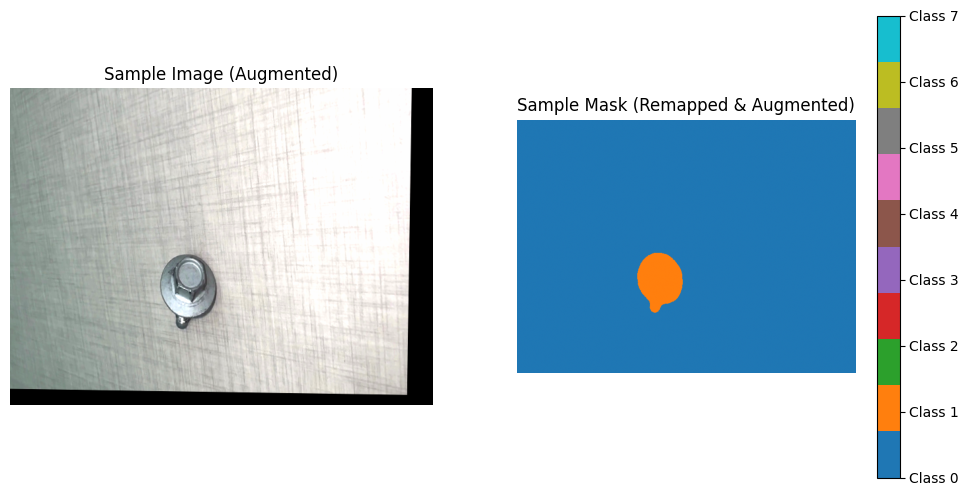

In [21]:
# @title Step 15: Define Custom Dataset Class (Corrected Index Check)

class BatteryComponentDataset(Dataset):
    # (Dataset class definition includes robust error handling)
    def __init__(self, image_mask_pairs, gcs_bucket_obj, lookup_table, transform=None):
        """
        Args:
            image_mask_pairs (list): List of tuples (image_gcs_path, mask_gcs_path).
            gcs_bucket_obj (google.cloud.storage.Bucket): Initialized GCS bucket object.
            lookup_table (np.array): Numpy array for remapping mask labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pairs = image_mask_pairs
        self.bucket = gcs_bucket_obj
        self.lookup_table = lookup_table
        self.transform = transform
        self.imagenet_mean = np.array([0.485, 0.456, 0.406]) # Store for dummy data if needed
        self.imagenet_std = np.array([0.229, 0.224, 0.225]) # Store for dummy data if needed

    def __len__(self):
        # Return 0 if pairs list is None or empty
        return len(self.pairs) if self.pairs else 0


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # --- Robust handling for empty list or invalid index ---
        dataset_len = len(self.pairs) if self.pairs else 0
        # *** CORRECTED CHECK: Removed isinstance(idx, int) ***
        if dataset_len == 0 or idx < 0 or idx >= dataset_len:
             print(f"Warning: Invalid index {idx} for dataset length {dataset_len}. Attempting fallback.")
             # If invalid, try returning the first item if possible
             if dataset_len > 0:
                 idx = 0
                 print("Falling back to index 0.")
             else:
                 print("Error: Dataset is empty, cannot fallback.")
                 # Create and return dummy data if dataset is truly empty
                 dummy_image_np = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
                 dummy_mask_np = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
                 image_tensor = torch.zeros((3, IMG_HEIGHT, IMG_WIDTH), dtype=torch.float32)
                 mask_tensor = torch.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=torch.long)
                 # Apply dummy transform
                 if self.transform:
                      dummy_transform = A.Compose([ A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_NEAREST), A.Normalize(mean=self.imagenet_mean, std=self.imagenet_std), ToTensorV2() ])
                      try:
                           augmented = dummy_transform(image=dummy_image_np, mask=dummy_mask_np)
                           image_tensor, mask_tensor = augmented['image'], augmented['mask'].long()
                      except: pass
                 return {"image": image_tensor, "mask": mask_tensor}
        # --- End robust handling ---


        try:
             img_path, mask_path = self.pairs[idx]
        except IndexError:
             print(f"Error: Caught IndexError accessing self.pairs[{idx}] despite checks. Len={dataset_len}")
             # Fallback to dummy data if error occurs even after checks
             dummy_image_np = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
             dummy_mask_np = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
             image_tensor = torch.zeros((3, IMG_HEIGHT, IMG_WIDTH), dtype=torch.float32)
             mask_tensor = torch.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=torch.long)
             if self.transform:
                  dummy_transform = A.Compose([ A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_NEAREST), A.Normalize(mean=self.imagenet_mean, std=self.imagenet_std), ToTensorV2() ])
                  try:
                       augmented = dummy_transform(image=dummy_image_np, mask=dummy_mask_np)
                       image_tensor, mask_tensor = augmented['image'], augmented['mask'].long()
                  except: pass
             return {"image": image_tensor, "mask": mask_tensor}


        # Load image (returns PIL Image, converted to RGB)
        image = load_image_from_gcs(img_path, self.bucket)
        # Load mask (returns numpy array, single channel L)
        mask = load_mask_from_gcs(mask_path, self.bucket)

        # Handle potential loading errors (This section might now be less likely to hit the 'next sample' logic due to __getitem__ fixes)
        if image is None or mask is None:
            print(f"Warning: Failed to load image or mask for index {idx}. Paths: {img_path}, {mask_path}.")
            # Return dummy data for this specific failure
            dummy_image_np = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
            dummy_mask_np = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
            image_tensor = torch.zeros((3, IMG_HEIGHT, IMG_WIDTH), dtype=torch.float32)
            mask_tensor = torch.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=torch.long)
            if self.transform:
                dummy_transform = A.Compose([ A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_NEAREST), A.Normalize(mean=self.imagenet_mean, std=self.imagenet_std), ToTensorV2() ])
                try:
                    augmented = dummy_transform(image=dummy_image_np, mask=dummy_mask_np)
                    image_tensor, mask_tensor = augmented['image'], augmented['mask'].long()
                except: pass
            return {"image": image_tensor, "mask": mask_tensor}


        # Remap mask labels
        if not mask.flags.writeable:
             mask = mask.copy()
        mask_remapped = remap_mask_labels(mask, self.lookup_table)

        # Convert PIL image to numpy array for albumentations
        image_np = np.array(image)

        # Apply transformations
        if self.transform:
            try:
                augmented = self.transform(image=image_np, mask=mask_remapped)
                image_tensor = augmented['image']
                mask_tensor = augmented['mask'] # Albumentations ToTensorV2 handles mask type
            except Exception as e:
                 print(f"Error during augmentation for index {idx}: {e}. Paths: {img_path}, {mask_path}")
                 # Fallback to basic transform or dummy data? Let's try basic.
                 basic_transform = A.Compose([
                     A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_NEAREST),
                     A.Normalize(mean=self.imagenet_mean, std=self.imagenet_std),
                     ToTensorV2(),
                 ])
                 try:
                      augmented = basic_transform(image=image_np, mask=mask_remapped)
                      image_tensor = augmented['image']
                      mask_tensor = augmented['mask']
                 except Exception as basic_e:
                      print(f"Fallback basic transform failed: {basic_e}. Returning dummy data.")
                      image_tensor = torch.zeros((3, IMG_HEIGHT, IMG_WIDTH), dtype=torch.float32)
                      mask_tensor = torch.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=torch.long)

        else:
            # Basic conversion if no transforms (should not happen with setup)
            image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0
            mask_tensor = torch.from_numpy(mask_remapped)

        # Ensure mask is LongTensor for CrossEntropyLoss
        mask_tensor = mask_tensor.long()

        return {"image": image_tensor, "mask": mask_tensor}


# --- Create Datasets ---
# (Code remains the same as the version with the test set)
train_dataset = BatteryComponentDataset(train_pairs, gcs_bucket, lookup_table, transform=train_transform) if train_pairs else None
val_dataset = BatteryComponentDataset(val_pairs, gcs_bucket, lookup_table, transform=val_transform) if val_pairs else None
test_dataset = BatteryComponentDataset(test_pairs, gcs_bucket, lookup_table, transform=val_transform) if test_pairs else None

print("\nDatasets created.")
print(f"Train dataset size: {len(train_dataset) if train_dataset else 0}")
print(f"Validation dataset size: {len(val_dataset) if val_dataset else 0}")
print(f"Test dataset size: {len(test_dataset) if test_dataset else 0}")


# --- Create DataLoaders ---
# (Code remains the same as the version with the test set)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True if train_dataset and len(train_dataset) > BATCH_SIZE else False, drop_last=True) if train_dataset and len(train_dataset) > 0 else None
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True if val_dataset and len(val_dataset) > BATCH_SIZE else False) if val_dataset and len(val_dataset) > 0 else None
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True if test_dataset and len(test_dataset) > 0 else False) if test_dataset and len(test_dataset) > 0 else None

print("\nDataLoaders created.")
print(f"Number of training batches: {len(train_loader) if train_loader else 0}")
print(f"Number of validation batches: {len(val_loader) if val_loader else 0}")
print(f"Number of test batches: {len(test_loader) if test_loader else 0}")


# --- Optional: Visualize a sample from the DataLoader to verify ---
# (Visualization code remains the same)
print("\nVisualizing one sample from training loader (if available)...")
# ... (Keep the visualization block as it was) ...
if train_loader:
    try:
        # Make sure dataset is not empty before trying iter
        if len(train_loader.dataset) > 0:
             sample_batch = next(iter(train_loader))
             img_sample = sample_batch['image'][0]
             mask_sample = sample_batch['mask'][0]

             print(f"Image batch shape: {sample_batch['image'].shape}")
             print(f"Mask batch shape: {sample_batch['mask'].shape}")
             print(f"Image sample shape: {img_sample.shape}")
             print(f"Mask sample shape: {mask_sample.shape}")
             print(f"Image sample dtype: {img_sample.dtype}")
             print(f"Mask sample dtype: {mask_sample.dtype}")
             print(f"Unique values in mask sample: {torch.unique(mask_sample)}")

             # Reverse normalization for display
             img_display = img_sample.permute(1, 2, 0).cpu().numpy() # CHW -> HWC
             mean = np.array(imagenet_mean)
             std = np.array(imagenet_std)
             img_display = std * img_display + mean
             img_display = np.clip(img_display, 0, 1)

             mask_display = mask_sample.cpu().numpy()

             fig, ax = plt.subplots(1, 2, figsize=(12, 6))
             ax[0].imshow(img_display)
             ax[0].set_title("Sample Image (Augmented)")
             ax[0].axis('off')
             # Use a suitable colormap for masks, ensure vmin/vmax cover your classes
             im = ax[1].imshow(mask_display, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
             ax[1].set_title("Sample Mask (Remapped & Augmented)")
             ax[1].axis('off')
             # Add colorbar to understand mask labels
             cbar = fig.colorbar(im, ax=ax[1], ticks=np.arange(NUM_CLASSES))
             cbar.ax.set_yticklabels([f'Class {i}' for i in range(NUM_CLASSES)]) # Label classes
             plt.show()
        else:
             print("Training dataset is empty, cannot visualize sample.")

    except StopIteration:
         print("Error: Training DataLoader is empty or could not fetch a batch.")
    except Exception as e:
        print(f"Error visualizing sample: {e}")
        print("Check dataset loading and transformations.")
else:
     print("Training DataLoader not created (dataset likely empty). Skipping visualization.")

In [16]:
# @title Step 16: Define Model, Loss, Optimizer, Metrics

# --- Load Model ---
# (Model loading code remains the same)
print(f"Loading model: {MODEL_ARCH}")
if MODEL_ARCH == 'deeplabv3_resnet50':
    weights = DeepLabV3_ResNet50_Weights.DEFAULT # Use default weights (COCO pre-trained)
    model = deeplabv3_resnet50(weights=weights)
    # Modify the final classifier layer for our number of classes
    # The classifier head in deeplabv3 is model.classifier[-1]
    model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
    # Also modify auxiliary classifier if it exists (depends on weights version)
    if hasattr(model, 'aux_classifier') and model.aux_classifier is not None:
         model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))

elif MODEL_ARCH == 'fcn_resnet50':
    weights = FCN_ResNet50_Weights.DEFAULT
    model = fcn_resnet50(weights=weights)
    model.classifier[-1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
    if hasattr(model, 'aux_classifier') and model.aux_classifier is not None:
        model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
else:
    raise ValueError(f"Unsupported MODEL_ARCH: {MODEL_ARCH}")

model = model.to(device)
print(f"Model loaded and moved to {device}.")

# --- Loss Function ---
# (Class weighting logic remains the same)
class_weights = None
if USE_CLASS_WEIGHTING:
    print("Calculating class weights (may take a while)...")
    if train_loader is None or len(train_loader.dataset) == 0:
        print("Warning: Training data unavailable, cannot calculate class weights.")
    else:
        label_counts = np.zeros(NUM_CLASSES)
        num_samples_for_weights = min(len(train_dataset), 5000)
        print(f"Calculating weights based on approx {num_samples_for_weights} training samples...")
        # Create a temporary loader for weight calculation if main loader has shuffle=True
        temp_loader_weights = DataLoader(train_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=1)

        processed_samples = 0
        for batch in tqdm(temp_loader_weights, desc="Counting labels for weights"):
            masks = batch['mask'].numpy() # (B, H, W)
            unique, counts = np.unique(masks, return_counts=True)
            for label, count in zip(unique, counts):
                if 0 <= label < NUM_CLASSES:
                    label_counts[label] += count
            processed_samples += masks.shape[0]
            if processed_samples >= num_samples_for_weights:
                 break
        del temp_loader_weights # Free memory

        print(f"Raw label counts (from ~{processed_samples} samples): {label_counts}")
        label_counts = np.maximum(label_counts, 1) # Avoid division by zero
        total_pixels = label_counts.sum()
        class_weights_inv = total_pixels / (NUM_CLASSES * label_counts)
        # class_weights_inv /= np.mean(class_weights_inv) # Normalize by mean
        class_weights_inv /= class_weights_inv.sum() # Normalize weights to sum to 1

        class_weights = torch.tensor(class_weights_inv, dtype=torch.float).to(device)
        print("Class weights calculated (normalized):", class_weights)
else:
     print("Class weighting disabled.")

criterion = nn.CrossEntropyLoss(weight=class_weights) # Pass None if not using weights
print(f"Loss function: CrossEntropyLoss (Weights: {'Enabled' if class_weights is not None else 'Disabled'})")


# --- Optimizer ---
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=OPTIMIZER_WEIGHT_DECAY)
print(f"Optimizer: AdamW (LR={LEARNING_RATE}, WD={OPTIMIZER_WEIGHT_DECAY})")

# --- Learning Rate Scheduler (Optional) ---
scheduler = None
if USE_LR_SCHEDULER:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE, verbose=True)
    print(f"LR Scheduler: ReduceLROnPlateau (Mode=max, Monitor=val_mIoU, Patience={SCHEDULER_PATIENCE}, Factor={SCHEDULER_FACTOR})")


# --- Metrics (using torchmetrics) ---
# Base metrics
jaccard_macro_base = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, average='macro', ignore_index=None).to(device) # mIoU
jaccard_none_base = torchmetrics.JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, average='none', ignore_index=None).to(device) # Per-class IoU
accuracy_macro_base = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device) # Mean class accuracy

# Metric collections for each phase (cloning ensures independent states)
metric_collection_train = torchmetrics.MetricCollection({
    'train_mIoU': jaccard_macro_base.clone(),
    'train_pixelAcc': accuracy_macro_base.clone()
})
metric_collection_val = torchmetrics.MetricCollection({
    'val_mIoU': jaccard_macro_base.clone(),
    'val_pixelAcc': accuracy_macro_base.clone()
})
# For test set - reuse validation collection structure, will be reset before use
metric_collection_test = metric_collection_val.clone()
# For per-class IoU during validation and test
per_class_iou_metric = jaccard_none_base.clone()


print("Metrics initialized (mIoU, Pixel Accuracy) for train, validation, and test.")

Loading model: deeplabv3_resnet50
Model loaded and moved to cuda.
Class weighting disabled.
Loss function: CrossEntropyLoss (Weights: Disabled)
Optimizer: AdamW (LR=0.0001, WD=1e-05)
LR Scheduler: ReduceLROnPlateau (Mode=max, Monitor=val_mIoU, Patience=2, Factor=0.1)
Metrics initialized (mIoU, Pixel Accuracy) for train, validation, and test.


Early stopping enabled: Patience=2, Min Delta=0.0001

--- Starting Training ---

Epoch 1/3
--------------------


Epoch 1/3 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.7770 | train_mIoU: 0.4669 train_pixelAcc: 0.6606 


Epoch 1/3 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1 Val Loss: 0.1427 | val_mIoU: 0.7528 val_pixelAcc: 0.8467 
  Per-Class IoU: bg: 0.980 bolt: 0.581 busbar: 0.753 cable: 0.805 connector: 0.621 nut: 0.772 film: 0.782 cover: 0.729 
Validation mIoU improved (-1.0000 --> 0.7528). Saving model...
*** Best model saved to /content/best_segmentation_model.pth ***
Val loss improved to 0.1427. Resetting early stopping counter.
--------------------

Epoch 2/3
--------------------


Epoch 2/3 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.1403 | train_mIoU: 0.7821 train_pixelAcc: 0.8574 


Epoch 2/3 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 Val Loss: 0.0696 | val_mIoU: 0.8081 val_pixelAcc: 0.8945 
  Per-Class IoU: bg: 0.984 bolt: 0.689 busbar: 0.774 cable: 0.817 connector: 0.717 nut: 0.842 film: 0.876 cover: 0.766 
Validation mIoU improved (0.7528 --> 0.8081). Saving model...
*** Best model saved to /content/best_segmentation_model.pth ***
Val loss improved to 0.0696. Resetting early stopping counter.
--------------------

Epoch 3/3
--------------------


Epoch 3/3 [Train]:   0%|          | 0/456 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0930 | train_mIoU: 0.8057 train_pixelAcc: 0.8775 


Epoch 3/3 [Val]:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 3 Val Loss: 0.0532 | val_mIoU: 0.8139 val_pixelAcc: 0.8848 
  Per-Class IoU: bg: 0.985 bolt: 0.678 busbar: 0.800 cable: 0.886 connector: 0.784 nut: 0.814 film: 0.888 cover: 0.675 
Validation mIoU improved (0.8081 --> 0.8139). Saving model...
*** Best model saved to /content/best_segmentation_model.pth ***
Val loss improved to 0.0532. Resetting early stopping counter.
--------------------
--- Training Finished ---
Epochs Run: 3
Total Training Time: 34m 40s
Best Validation mIoU achieved: 0.8139 (at epoch saved)


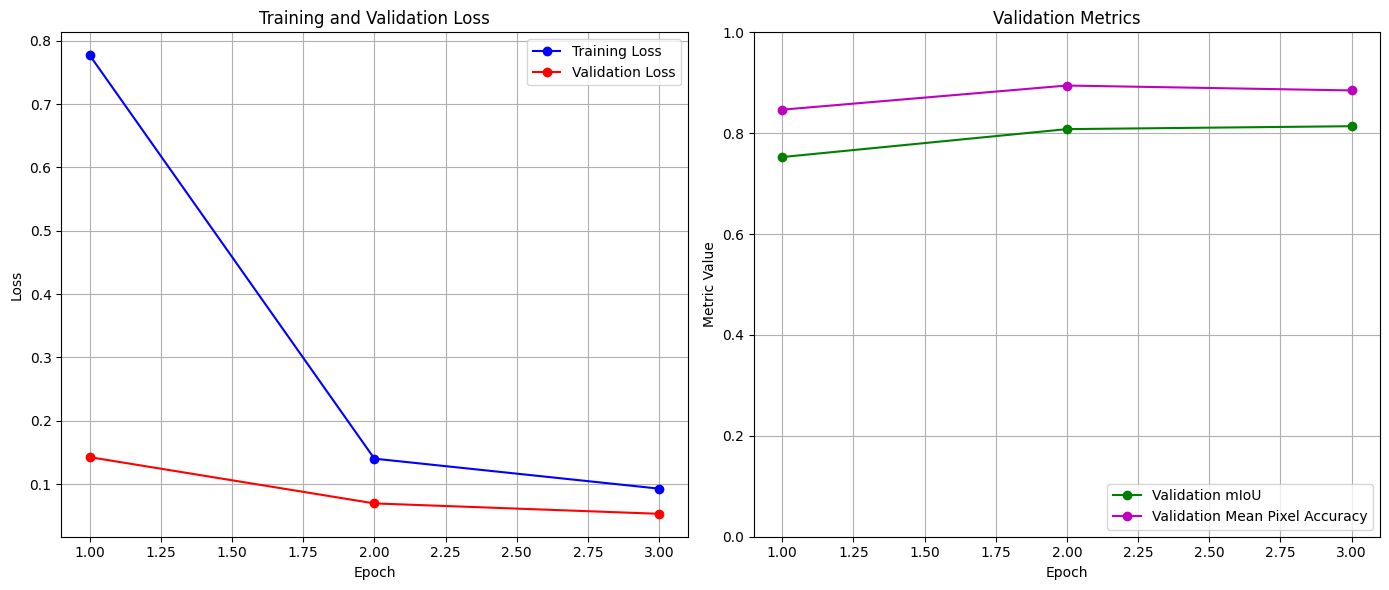

In [17]:
# @title Step 17: Training and Validation Loop (with Early Stopping)

def train_one_epoch(model, loader, criterion, optimizer, device, epoch_num, metric_collection_train):
    # (Function definition remains the same)
    model.train()
    metric_collection_train.reset()
    running_loss = 0.0
    num_samples = 0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num+1}/{NUM_EPOCHS} [Train]", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        if batch is None or 'image' not in batch or 'mask' not in batch: continue
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        if images.shape[0] == 0: continue

        optimizer.zero_grad()
        try:
            outputs = model(images)
            main_output = outputs['out']
            loss = criterion(main_output, masks)
            if 'aux' in outputs and outputs['aux'] is not None:
                aux_loss = criterion(outputs['aux'], masks)
                loss = loss + 0.4 * aux_loss
        except Exception as e:
             print(f"\nError during forward/loss calculation in training batch {batch_idx}: {e}")
             continue

        try:
            loss.backward()
            optimizer.step()
        except Exception as e:
             print(f"\nError during backward/optimizer step in training batch {batch_idx}: {e}")
             continue

        preds = torch.argmax(main_output.detach(), dim=1)
        metric_collection_train.update(preds, masks)

        running_loss += loss.item() * images.size(0)
        num_samples += images.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    if num_samples == 0:
         print(f"Epoch {epoch_num+1} Train: No samples processed.")
         return 0.0, {}
    epoch_loss = running_loss / num_samples
    epoch_metrics = metric_collection_train.compute()
    print(f"Epoch {epoch_num+1} Train Loss: {epoch_loss:.4f}", end=" | ")
    for name, value in epoch_metrics.items():
        print(f"{name}: {value:.4f}", end=" ")
    print()
    return epoch_loss, epoch_metrics


def validate_one_epoch(model, loader, criterion, device, epoch_num, metric_collection_val, per_class_metric):
    # (Function definition remains the same)
    model.eval()
    metric_collection_val.reset()
    per_class_metric.reset()
    running_loss = 0.0
    num_samples = 0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num+1}/{NUM_EPOCHS} [Val]", leave=False)

    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            if batch is None or 'image' not in batch or 'mask' not in batch: continue
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            if images.shape[0] == 0: continue

            try:
                outputs = model(images)
                main_output = outputs['out']
                loss = criterion(main_output, masks)
            except Exception as e:
                 print(f"\nError during forward/loss calculation in validation batch {batch_idx}: {e}")
                 continue

            preds = torch.argmax(main_output.detach(), dim=1)
            metric_collection_val.update(preds, masks)
            per_class_metric.update(preds, masks)

            running_loss += loss.item() * images.size(0)
            num_samples += images.size(0)
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    if num_samples == 0:
         print(f"Epoch {epoch_num+1} Val: No samples processed.")
         return 0.0, {}, torch.zeros(NUM_CLASSES)
    epoch_loss = running_loss / num_samples
    epoch_metrics = metric_collection_val.compute()
    per_class_iou = per_class_metric.compute()

    print(f"Epoch {epoch_num+1} Val Loss: {epoch_loss:.4f}", end=" | ")
    for name, value in epoch_metrics.items():
         print(f"{name}: {value:.4f}", end=" ")
    print()
    class_names = ["bg", "bolt", "busbar", "cable", "connector", "nut", "film", "cover"]
    print("  Per-Class IoU:", end=" ")
    for i, iou in enumerate(per_class_iou):
         class_name = class_names[i] if i < len(class_names) else f"C{i}"
         print(f"{class_name}: {iou:.3f}", end=" ")
    print()
    return epoch_loss, epoch_metrics, per_class_iou


# --- Training Loop ---
best_val_miou = -1.0
history = {'train_loss': [], 'val_loss': [], 'val_mIoU': [], 'val_pixelAcc': []}
epochs_completed = 0 # Keep track of actual epochs run

# --- Early Stopping Initialization ---
if USE_EARLY_STOPPING:
    epochs_no_improve = 0
    best_val_loss_for_stopping = float('inf')
    print(f"Early stopping enabled: Patience={EARLY_STOPPING_PATIENCE}, Min Delta={EARLY_STOPPING_MIN_DELTA}")
# ------------------------------------

# Check if loaders exist before starting training
if not train_loader or not val_loader:
     print("\nError: Training or Validation DataLoader is not available. Check dataset splits and sizes.")
     print("Skipping training loop.")
else:
    print("\n--- Starting Training ---")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        epochs_completed = epoch + 1 # Track actual epochs run
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        print("-" * 20)

        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, metric_collection_train)
        val_loss, val_metrics, _ = validate_one_epoch(model, val_loader, criterion, device, epoch, metric_collection_val, per_class_iou_metric) # Pass per-class metric here

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_mIoU'].append(val_metrics.get('val_mIoU', torch.tensor(0.0)).item())
        history['val_pixelAcc'].append(val_metrics.get('val_pixelAcc', torch.tensor(0.0)).item())

        current_val_miou = val_metrics.get('val_mIoU', torch.tensor(-1.0))

        # Learning rate scheduling step (based on validation mIoU)
        if USE_LR_SCHEDULER and scheduler:
            scheduler.step(current_val_miou)

        # Save the best model based on validation mIoU (primary performance metric)
        if current_val_miou > best_val_miou:
            print(f"Validation mIoU improved ({best_val_miou:.4f} --> {current_val_miou:.4f}). Saving model...")
            best_val_miou = current_val_miou
            try:
                torch.save(model.state_dict(), CHECKPOINT_PATH)
                print(f"*** Best model saved to {CHECKPOINT_PATH} ***")
            except Exception as save_e:
                 print(f"!!! Error saving model checkpoint: {save_e} !!!")

        # --- Early Stopping Check (based on validation loss) ---
        if USE_EARLY_STOPPING:
            # Check if val_loss improved significantly
            if val_loss < best_val_loss_for_stopping - EARLY_STOPPING_MIN_DELTA:
                best_val_loss_for_stopping = val_loss
                epochs_no_improve = 0
                print(f"Val loss improved to {val_loss:.4f}. Resetting early stopping counter.")
            else:
                epochs_no_improve += 1
                print(f"Val loss ({val_loss:.4f}) did not improve significantly from best ({best_val_loss_for_stopping:.4f}). Counter: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE}")

            if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                print(f"\n--- Early Stopping Triggered ---")
                print(f"Validation loss did not improve for {EARLY_STOPPING_PATIENCE} consecutive epochs.")
                break # Exit the training loop
        # ----------------------------------------------------

        print("-" * 20)

    end_time = time.time()
    total_time = end_time - start_time
    print(f"--- Training Finished ---")
    print(f"Epochs Run: {epochs_completed}") # Report actual epochs run
    print(f"Total Training Time: {total_time // 60:.0f}m {total_time % 60:.0f}s")
    print(f"Best Validation mIoU achieved: {best_val_miou:.4f} (at epoch saved)")


    # --- Plot Training History ---
    if epochs_completed > 0: # Use actual epochs completed for plotting
        epochs_range_actual = range(1, epochs_completed + 1) # Range based on actual epochs run
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range_actual, history['train_loss'], 'bo-', label='Training Loss')
        plt.plot(epochs_range_actual, history['val_loss'], 'ro-', label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range_actual, history['val_mIoU'], 'go-', label='Validation mIoU')
        plt.plot(epochs_range_actual, history['val_pixelAcc'], 'mo-', label='Validation Mean Pixel Accuracy')
        plt.legend(loc='lower right')
        plt.title('Validation Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.ylim([0, 1]) # Metrics are typically between 0 and 1
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print("No epochs were run, skipping history plot.")

In [18]:
# @title Step 17b: Evaluate Best Model on Test Set (Corrected Model Loading)

print("\n--- Evaluating Best Model on Test Set ---")

# Check if a checkpoint exists and the test loader is valid
if not os.path.exists(CHECKPOINT_PATH):
     print(f"Checkpoint file not found at {CHECKPOINT_PATH}. Cannot evaluate on test set.")
elif test_loader is None or len(test_loader.dataset) == 0:
     print("Test loader is empty or not created. Cannot evaluate on test set.")
else:
    model_test = None # Initialize to None
    # --- Corrected Model Re-initialization ---
    # Re-initialize model structure *matching the training setup*
    # to ensure aux_classifier exists if it was saved in the state_dict.
    print(f"Re-initializing model structure: {MODEL_ARCH}")
    if MODEL_ARCH == 'deeplabv3_resnet50':
        # Initialize with default weights to ensure aux classifier exists if expected
        model_test = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT) # <<< FIX: Use default weights initially
        # Now modify heads to match NUM_CLASSES *before* loading state_dict
        model_test.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
        # The aux classifier should exist now if it did during training
        if hasattr(model_test, 'aux_classifier') and model_test.aux_classifier is not None:
            model_test.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
            print("Auxiliary classifier head modified.")
        else:
             # This case shouldn't happen if training model had aux head, but good check
             print("Warning: Re-initialized model for testing lacks aux_classifier, potential mismatch with saved state_dict if it contained aux keys.")

    elif MODEL_ARCH == 'fcn_resnet50':
         # Apply similar logic for FCN if you used that
         model_test = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT) # <<< FIX: Use default weights initially
         model_test.classifier[-1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
         if hasattr(model_test, 'aux_classifier') and model_test.aux_classifier is not None:
            model_test.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
            print("Auxiliary classifier head modified.")
         else:
              print("Warning: Re-initialized FCN model for testing lacks aux_classifier.")
    else:
        print(f"ERROR: MODEL_ARCH {MODEL_ARCH} not recognized during test reloading.")
        model_test = None
    # --- End Model Re-initialization ---


    # --- Load State Dict and Evaluate ---
    if model_test is not None:
        try:
            print(f"Loading best model weights from {CHECKPOINT_PATH} for test evaluation...")
            map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            # Load the saved weights into the correctly structured model
            model_test.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=map_location))
            model_test.to(device)
            model_test.eval() # Set to evaluation mode
            print("Model loaded successfully.")

            # Reset metric collections before test evaluation
            metric_collection_test.reset() # Use the dedicated test collection
            per_class_iou_metric.reset() # Reset per-class metric too

            test_loss = 0.0 # Can optionally calculate test loss too
            num_test_samples = 0
            progress_bar_test = tqdm(test_loader, desc="Testing", leave=False)

            with torch.no_grad():
                for batch_idx, batch in enumerate(progress_bar_test):
                    # Added checks for invalid batch data
                    if batch is None or 'image' not in batch or 'mask' not in batch:
                         print(f"Skipping invalid batch {batch_idx} in testing")
                         continue
                    images = batch['image'].to(device)
                    masks = batch['mask'].to(device)

                    if images.shape[0] == 0: continue # Skip if batch size is 0

                    try:
                        outputs = model_test(images)
                        main_output = outputs['out']

                        # Optional: Calculate loss on test set
                        loss = criterion(main_output, masks) # Use the same criterion
                        test_loss += loss.item() * images.size(0)
                        num_test_samples += images.size(0)

                        # Update metrics
                        preds = torch.argmax(main_output.detach(), dim=1)
                        metric_collection_test.update(preds, masks)
                        per_class_iou_metric.update(preds, masks)

                    except Exception as e:
                         print(f"\nError during testing batch {batch_idx}: {e}")
                         print(f"Image shape: {images.shape}, Mask shape: {masks.shape}")
                         continue # Skip batch on error

            # Compute final test metrics
            if num_test_samples > 0:
                 final_test_loss = test_loss / num_test_samples
                 # Compute metrics from the dedicated test collection
                 final_test_metrics = metric_collection_test.compute()
                 final_per_class_iou = per_class_iou_metric.compute()

                 print("\n--- Test Set Results ---")
                 print(f"Test Loss: {final_test_loss:.4f}")
                 # Fetch metrics using their keys in the test collection ('val_...' because cloned from val collection)
                 print(f"Test mIoU: {final_test_metrics.get('val_mIoU', torch.tensor(-1.0)):.4f}")
                 print(f"Test Mean Pixel Accuracy: {final_test_metrics.get('val_pixelAcc', torch.tensor(-1.0)):.4f}")

                 # Print per-class IoU
                 class_names = ["bg", "bolt", "busbar", "cable", "connector", "nut", "film", "cover"] # Short names
                 print("  Per-Class IoU:", end=" ")
                 for i, iou in enumerate(final_per_class_iou):
                     class_name = class_names[i] if i < len(class_names) else f"C{i}"
                     print(f"{class_name}: {iou:.3f}", end=" ")
                 print()
                 print("-------------------------")
            else:
                 print("No samples processed in the test set evaluation.")


        except FileNotFoundError:
            print(f"Error: Checkpoint file not found at {CHECKPOINT_PATH}. Cannot evaluate test set.")
        except Exception as e:
            # Catch potential errors during model loading or evaluation loop
            print(f"Error during test set evaluation process: {e}")
            import traceback
            traceback.print_exc() # Print detailed traceback for debugging
    else:
         print("Test model initialization failed. Cannot evaluate.")
# --- End Evaluation Block ---


--- Evaluating Best Model on Test Set ---
Re-initializing model structure: deeplabv3_resnet50
Auxiliary classifier head modified.
Loading best model weights from /content/best_segmentation_model.pth for test evaluation...
Model loaded successfully.


Testing:   0%|          | 0/98 [00:00<?, ?it/s]


--- Test Set Results ---
Test Loss: 0.0504
Test mIoU: 0.8197
Test Mean Pixel Accuracy: 0.8847
  Per-Class IoU: bg: 0.986 bolt: 0.713 busbar: 0.811 cable: 0.888 connector: 0.779 nut: 0.824 film: 0.908 cover: 0.648 
-------------------------


Setting inference source to Test Set.
Loading best model weights from /content/best_segmentation_model.pth
Re-initializing model structure for inference: deeplabv3_resnet50
Auxiliary classifier head modified for inference model.
Loading weights onto device: cuda
Best model loaded successfully for inference.

Running inference on 5 samples from the Test set...

--- Sample Index in Test Set: 1309 ---
Image Path: gs://segmentedimages/labelstudio/plastic_film/augment/augmented_images/task-17453_aug_cutout_medium_279.jpg


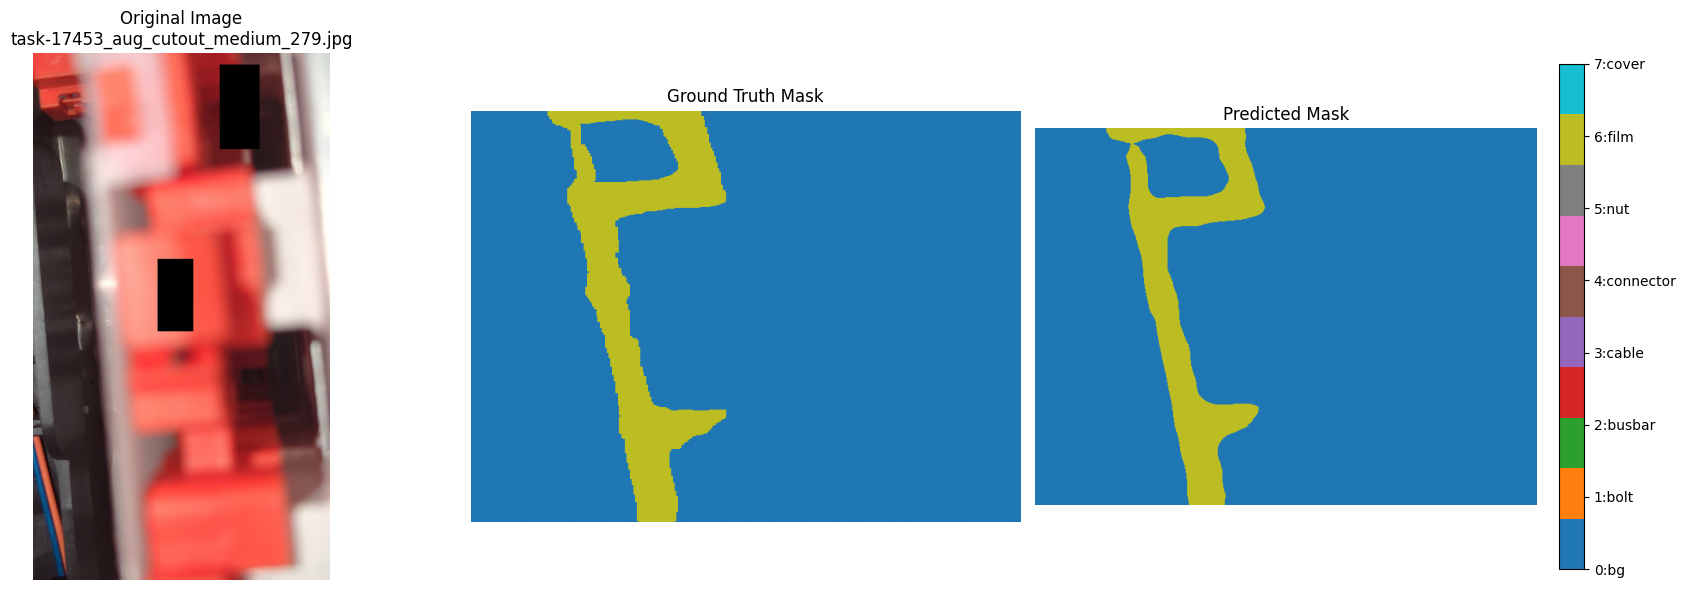


--- Sample Index in Test Set: 474 ---
Image Path: gs://segmentedimages/sreeni/bolt1/augment/augmented_images/4_frame_001750.jpg


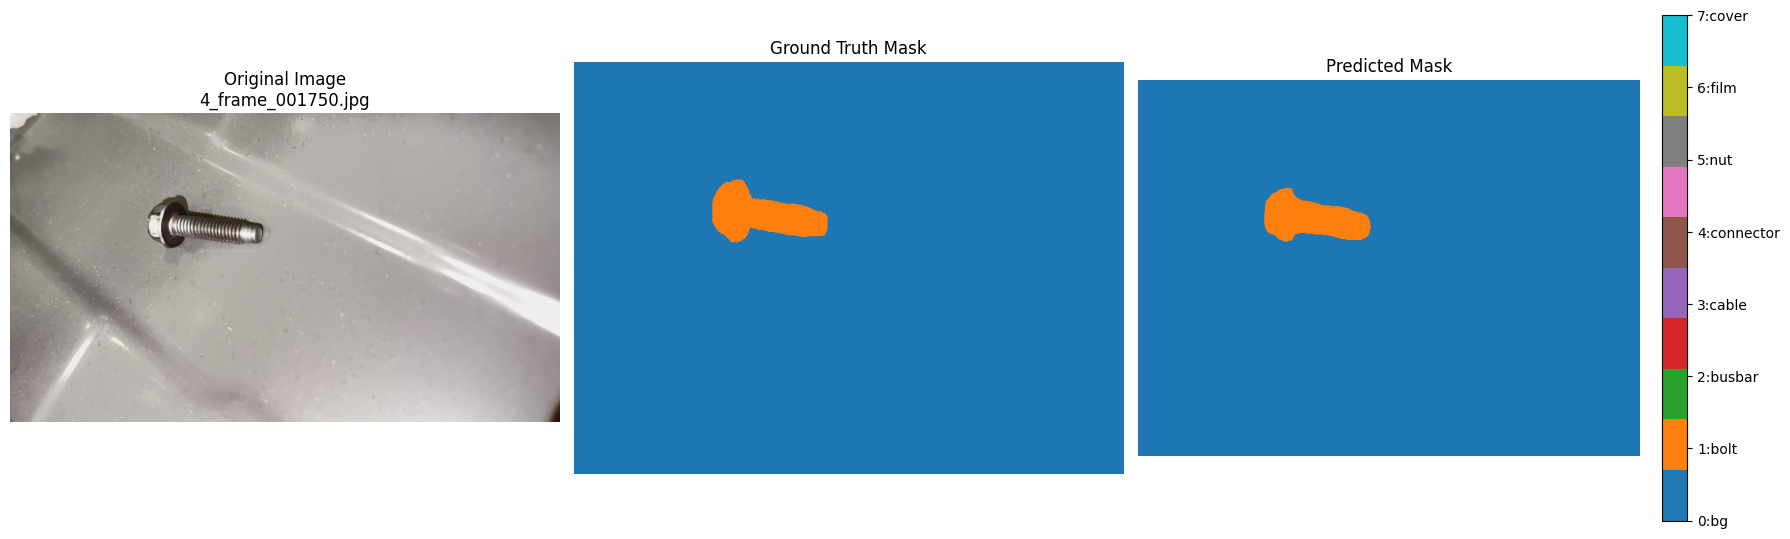


--- Sample Index in Test Set: 70 ---
Image Path: gs://segmentedimages/sreeni/connectors/augment/augmented_images/2_frame_0039_mix_mix_r-33_p13_b-0.1_-8.jpg


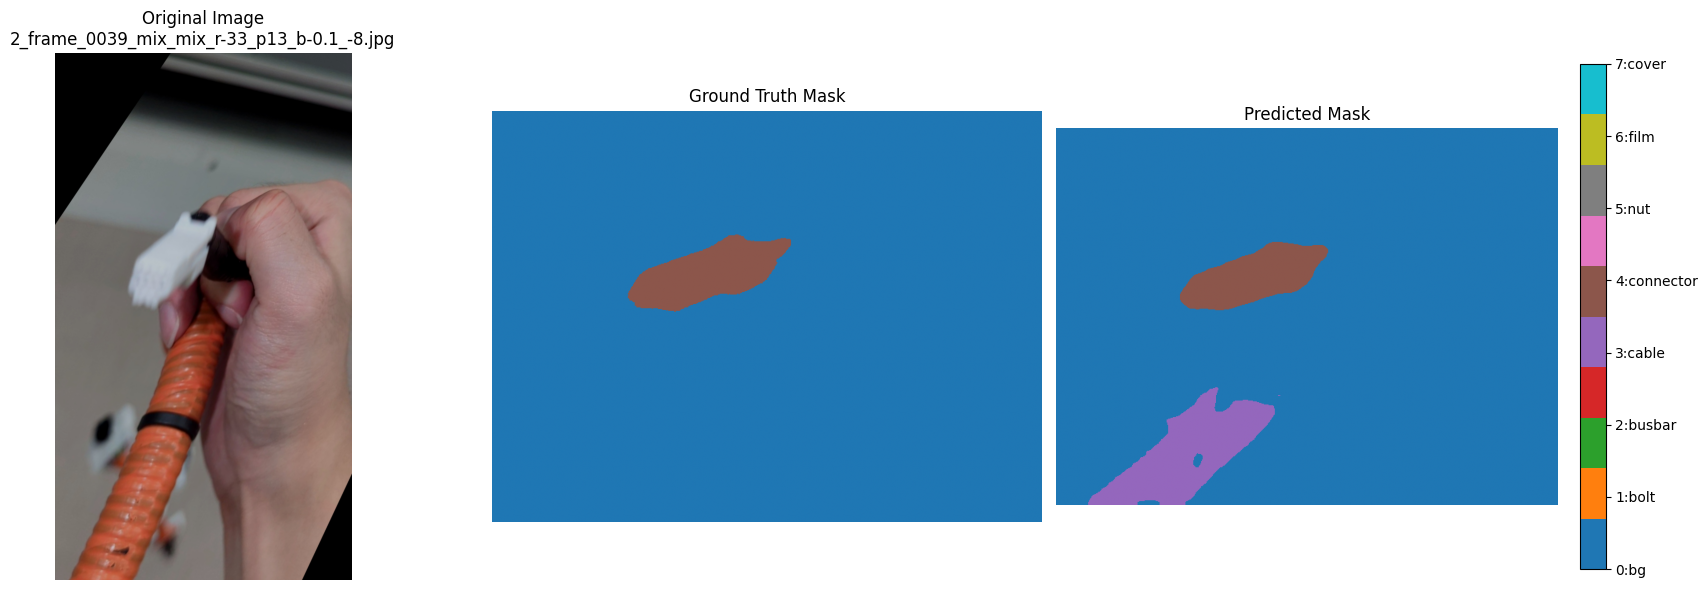


--- Sample Index in Test Set: 772 ---
Image Path: gs://segmentedimages/sreeni/plastic_cover/augment/augmented_images/4_frame_000130_noise_13.jpg


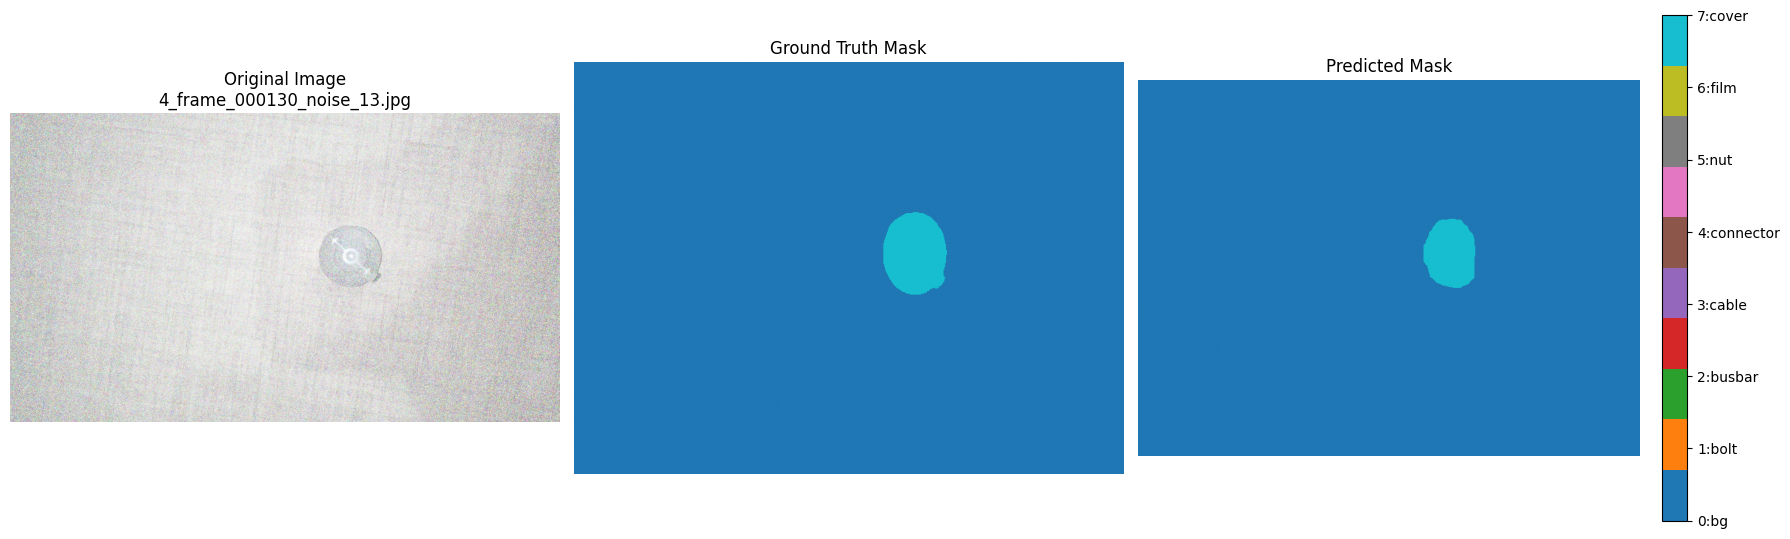


--- Sample Index in Test Set: 1003 ---
Image Path: gs://segmentedimages/sreeni/bolt1/augment/augmented_images/4_frame_001350aughflip1.jpg


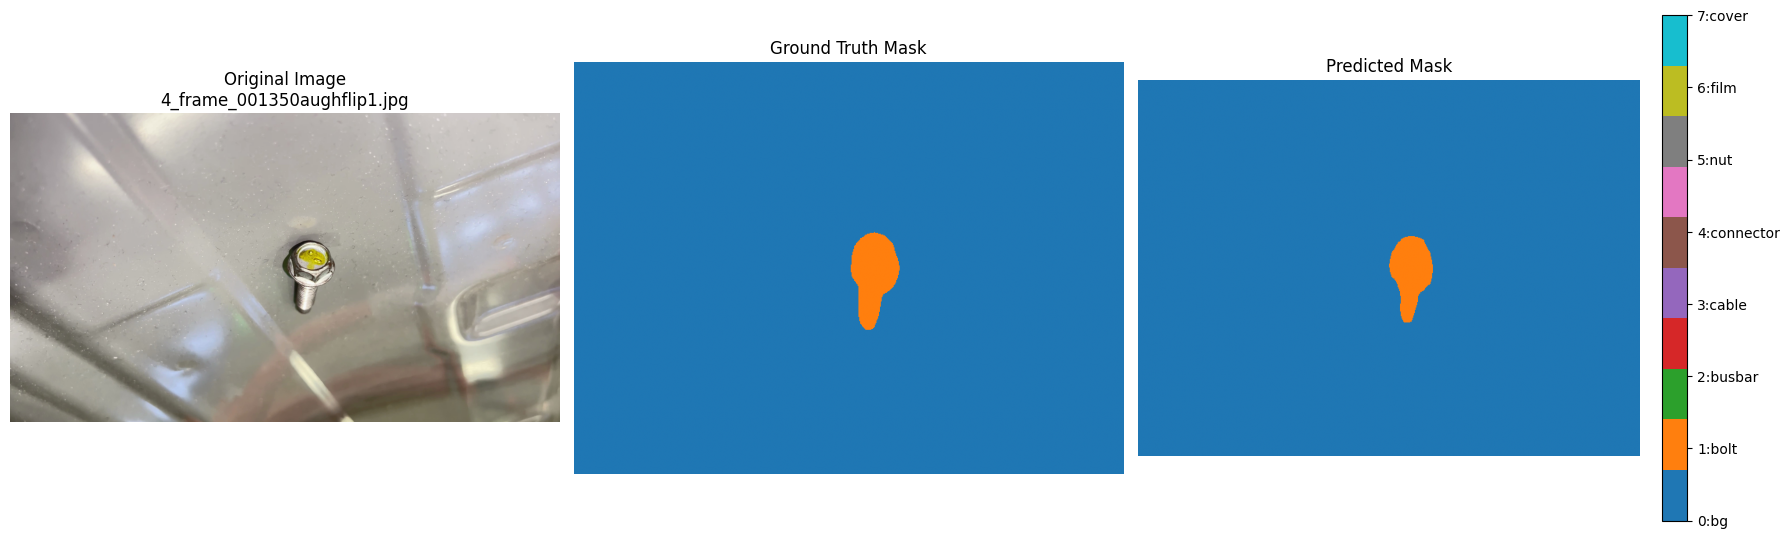


--- End of Script ---


In [22]:
# @title Step 18: Load Best Model and Evaluate (Optional: Example Inference on Test Set - Corrected)

# --- Visualization Setup ---
num_inference_samples = 5 # How many samples to visualize

# Check if test dataset and pairs exist before setting them for inference
if test_dataset and test_pairs:
    inference_dataset = test_dataset
    inference_pairs = test_pairs
    inference_set_name = "Test"
    print("Setting inference source to Test Set.")
elif val_dataset and val_pairs: # Fallback to validation set if test set is unavailable
     inference_dataset = val_dataset
     inference_pairs = val_pairs
     inference_set_name = "Validation"
     print("Warning: Test set not available, setting inference source to Validation Set.")
else:
    inference_dataset = None
    inference_pairs = None
    inference_set_name = "N/A"
    print("Warning: No Test or Validation set available for inference.")


# --- Load the best saved model weights ---
best_model = None # Initialize best_model
if os.path.exists(CHECKPOINT_PATH):
    print(f"Loading best model weights from {CHECKPOINT_PATH}")

    # --- Corrected Model Re-initialization for Inference ---
    # Re-initialize model structure *matching the training setup*
    print(f"Re-initializing model structure for inference: {MODEL_ARCH}")
    if MODEL_ARCH == 'deeplabv3_resnet50':
        # Initialize with default weights to ensure aux classifier exists if expected
        best_model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT) # <<< FIX: Use default weights
        # Now modify heads to match NUM_CLASSES *before* loading state_dict
        best_model.classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
        if hasattr(best_model, 'aux_classifier') and best_model.aux_classifier is not None:
            best_model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
            print("Auxiliary classifier head modified for inference model.")
        else:
             print("Warning: Re-initialized inference model lacks aux_classifier.")

    elif MODEL_ARCH == 'fcn_resnet50':
         best_model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT) # <<< FIX: Use default weights
         best_model.classifier[-1] = nn.Conv2d(512, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
         if hasattr(best_model, 'aux_classifier') and best_model.aux_classifier is not None:
            best_model.aux_classifier[-1] = nn.Conv2d(256, NUM_CLASSES, kernel_size=(1, 1), stride=(1, 1))
            print("Auxiliary classifier head modified for inference model.")
         else:
              print("Warning: Re-initialized FCN inference model lacks aux_classifier.")
    else:
        print(f"ERROR: MODEL_ARCH {MODEL_ARCH} not recognized during inference reloading.")
        best_model = None
    # --- End Model Re-initialization ---

    # --- Load State Dict ---
    if best_model is not None:
        try:
            map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Loading weights onto device: {map_location}")
            # Load the saved weights into the correctly structured model
            best_model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=map_location))
            best_model.to(device)
            best_model.eval() # Set to evaluation mode
            print("Best model loaded successfully for inference.")
        except FileNotFoundError: # Should be caught by os.path.exists, but defensive check
            print(f"Error: Checkpoint file disappeared at {CHECKPOINT_PATH}.")
            best_model = None
        except Exception as e:
            # Catch errors during loading (like the unexpected keys error)
            print(f"Error loading model state dict for inference: {e}")
            best_model = None # Set best_model to None if loading fails
else:
     print(f"Checkpoint file not found at {CHECKPOINT_PATH}. Cannot run inference.")
# --- End Loading Block ---


# --- Example Inference on a few Samples from the chosen dataset ---
if best_model and inference_dataset and len(inference_dataset) > 0:
    print(f"\nRunning inference on {num_inference_samples} samples from the {inference_set_name} set...")
    # Ensure we don't request more samples than available
    num_samples_to_show = min(num_inference_samples, len(inference_dataset))
    indices_to_show = np.random.choice(range(len(inference_dataset)), num_samples_to_show, replace=False)

    for sample_idx in indices_to_show:
        print(f"\n--- Sample Index in {inference_set_name} Set: {sample_idx} ---")
        try:
             sample = inference_dataset[sample_idx] # Get sample
        except Exception as getitem_e:
             print(f"Error getting sample {sample_idx} from dataset: {getitem_e}")
             continue # Skip this sample

        # Handle potential issues if dataset returns None or invalid structure
        if sample is None or 'image' not in sample or 'mask' not in sample:
             print(f"Skipping sample {sample_idx} due to invalid data returned by dataset.")
             continue

        # Get original paths using the correct pairs list
        try:
             raw_image_path, raw_mask_path = inference_pairs[sample_idx]
             print(f"Image Path: {raw_image_path}")
        except IndexError:
             print("Error: Could not retrieve original path for sample index.")
             raw_image_path = "Unknown"


        img_tensor = sample['image'].unsqueeze(0).to(device) # Add batch dim and move to device
        true_mask = sample['mask'] # Ground truth mask (tensor, H, W)

        with torch.no_grad():
            try:
                output = best_model(img_tensor)['out'] # Get model prediction (1, C, H, W)
                pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu() # (H, W) on CPU
            except Exception as infer_e:
                 print(f"Error during model inference for sample {sample_idx}: {infer_e}")
                 continue # Skip this sample

        # Load original image for better visualization context
        original_image_pil = load_image_from_gcs(raw_image_path, gcs_bucket) if raw_image_path != "Unknown" else None

        # Display
        plt.figure(figsize=(18, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        if original_image_pil:
            plt.imshow(original_image_pil)
            plt.title(f"Original Image\n{os.path.basename(raw_image_path)}")
        else:
             img_display = sample['image'].permute(1, 2, 0).cpu().numpy()
             mean = np.array(imagenet_mean); std = np.array(imagenet_std)
             img_display = std * img_display + mean; img_display = np.clip(img_display, 0, 1)
             plt.imshow(img_display)
             plt.title("Input Image (Original Load Failed or Path Unknown)")
        plt.axis('off')

        # Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.numpy(), cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        im = plt.imshow(pred_mask.numpy(), cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Predicted Mask")
        plt.axis('off')

        # Add a colorbar
        fig = plt.gcf()
        try:
            class_names = ["0:bg", "1:bolt", "2:busbar", "3:cable", "4:connector", "5:nut", "6:film", "7:cover"]
            cbar = fig.colorbar(im, ax=plt.gca(), ticks=np.arange(NUM_CLASSES), fraction=0.046, pad=0.04)
            cbar.ax.set_yticklabels(class_names[:NUM_CLASSES])
        except Exception as cbar_e:
             print(f"Warning: Could not create colorbar: {cbar_e}")

        plt.tight_layout()
        plt.show()

elif not best_model:
    print("\nSkipping inference example because the best model could not be loaded.")
else:
     print(f"\nSkipping inference example because the {inference_set_name} dataset is empty or unavailable.")

print("\n--- End of Script ---")